# Modeling Building Energy Consumption Capstone Project

## Capstone EDA


** Goal **

Use machine learning to predict future trends for a building's energy consumption with the minimal amount of data (days) possible. Another goal is to use additional variables to determine energy consumption abnormalities and create a varying envelope around the huilding's energy consumption.

**Methods and Models**

Some techniques I've implemented are regular bootstrapping, circular block bootstrapping, ARIMA, and an LSTM neural network. I'll also be splitting the data into train and test to determine whether my algorithms are making accurate predictions. 

**Risks**

Might have to change the scope of this project if I hit the proverbial "wall" when it comes to applying some of the methods and models I proposed. Already dropping using normal boostrapping and Circular Block Bootstrapping for my project because it doesn't seem to be the right method to help me achieve my goal.

**Data Cleaning and Munging Techniques**

The data I was given was relatively clean. For instance, there weren't blank or random symbols present in the datasets. However the data was given to me in multiple csv files, and some object types had to be converted. 

Some steps I took to clean the data involved:
- Concatenate multiple CSV files into one DataFrame to work with.
- Convert objects to timestamps and seperate the timesteps by year, month, day, hour and minute.
- Proper sorting of the data.
- Reseting the dataset's index.

**Data Dictionary**

This dictionary is for the two datasets of unique buildings I was given:

- cdd/hdd: cooling degree days, heating degree days. 

- tod15, tod30, tod45: 15 minute variables for each hour.

- interval_value - building's current energy demand

- prev_min & prev_max refer: previous day’s values. 

- next_temp: next hour’s temperature. 

- timestamp: time (as an object)

- is_holiday: binary classifier if day is holiday

- humidity: humidity for the given timeframe

- jan/feb/etc...: binary classifier for days in each month

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyflux as pf
import itertools
import patsy
import glob
from collections import deque
from sklearn import metrics
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, SGDRegressor, SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, cross_val_predict
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from arch.bootstrap import CircularBlockBootstrap

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


The dataset was given to me in multiple csv files so I first concatenated them together into one DataFrame

In [3]:
path_1 = 'Path on computer'

allFiles = glob.glob(path_1 + "/*.csv")
building = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
building = pd.concat(list_)

Looking at the basic properties of my dataset.

In [4]:
print building.shape

(101746, 29)


In [5]:
building.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101746 entries, 0 to 2468
Data columns (total 29 columns):
timestamp                    101746 non-null object
interval_value               101746 non-null float64
normalized_interval_value    101746 non-null float64
is_holiday                   101746 non-null int64
ocd_count                    101746 non-null int64
apr                          101746 non-null float64
aug                          101746 non-null float64
cdd                          101746 non-null float64
dec                          101746 non-null float64
feb                          101746 non-null float64
hdd                          101746 non-null float64
holiday                      101746 non-null float64
humidity                     101746 non-null float64
jul                          101746 non-null float64
jun                          101746 non-null float64
mar                          101746 non-null float64
may                          101746 non-null flo

In [6]:
building.columns

Index([u'timestamp', u'interval_value', u'normalized_interval_value',
       u'is_holiday', u'ocd_count', u'apr', u'aug', u'cdd', u'dec', u'feb',
       u'hdd', u'holiday', u'humidity', u'jul', u'jun', u'mar', u'may',
       u'next_temp', u'nov', u'ocd10_25_2016', u'ocd7_24_2014', u'oct',
       u'prev_max_temp', u'prev_min_temp', u'sep', u'sky', u'tod15', u'tod30',
       u'tod45'],
      dtype='object')

Convert timestamp column from object to timeseries. Break up timeseries into year, month, day, hour, minute. Create a days total column to see how many days has passed. Make a binary classifier for weekends and another classifer for days of the week. Reset index to properly sort dataframe. Dropped the first 184 rows as the beginning of the dataset was missing a couple of time intervals.

In [6]:
building["time"] = pd.to_datetime(building["timestamp"])
building["year"] = building["time"].map(lambda value: value.year)
building["month"] = building["time"].map(lambda value: value.month)
building["day"] = building["time"].map(lambda value: value.day)
building["hour"] = building["time"].map(lambda value: value.hour)
building["minute"] = building["time"].map(lambda value: value.minute)
building["dow"] = building["time"].map(lambda value: value.dayofweek)

building = building.sort_values(['year', 'month', 'day', 'hour', 'minute'])

start_date = building.time.min()
days_since_start = building.time - start_date
building['days_total'] = days_since_start.apply(lambda x: x.days)

weekend = []

for item in building.dow:
    if item == 5 or item == 6:
        weekend.append(1)
    else:
        weekend.append(0)
        
building["is_weekend"] = weekend

building = building[184:]

building = building.reset_index(drop=True)

In [7]:
building.head()

timestamp  interval_value  normalized_interval_value  is_holiday  \
0  04/19/2014 00:00          3835.2                     3835.2           0   
1  04/19/2014 00:15          3876.0                     3876.0           0   
2  04/19/2014 00:30          3824.8                     3824.8           0   
3  04/19/2014 00:45          3836.8                     3836.8           0   
4  04/19/2014 01:00          3760.8                     3760.8           0   

   ocd_count  apr  aug  cdd  dec  feb     ...      tod45                time  \
0          0  1.0  0.0  0.0  0.0  0.0     ...        0.0 2014-04-19 00:00:00   
1          0  1.0  0.0  0.0  0.0  0.0     ...        0.0 2014-04-19 00:15:00   
2          0  1.0  0.0  0.0  0.0  0.0     ...        0.0 2014-04-19 00:30:00   
3          0  1.0  0.0  0.0  0.0  0.0     ...        1.0 2014-04-19 00:45:00   
4          0  1.0  0.0  0.0  0.0  0.0     ...        0.0 2014-04-19 01:00:00   

   year  month  day  hour  minute  dow  days_total  is_weekend  
0  2014      4   19     0       0    5           7           1  
1  2014      4   19     0      15    5           7           1  
2  2014      4   19     0      30    5           7           1  
3  2014      4   19     0      45    5           7           1  
4  2014      4   19     1       0    5           7           1  

[5 rows x 38 columns]

Use linear regression and random forest to see which of the given variables (by their group) have the biggest effect on determining interval_value. 

In [8]:
#months R^2 = 0.06
#y, X = patsy.dmatrices('interval_value ~ apr + aug + dec + feb + jul + jun + mar + may + nov + oct + sep - 1', data=building, return_type='dataframe')

#temp weather R^2 = 0.38 linreg / 0.81 random forest
#y, X = patsy.dmatrices('interval_value ~ prev_max_temp + prev_min_temp + humidity + cdd + hdd + sky + next_temp - 1', data=building, return_type='dataframe')

#timestamp R^2 = 0.16 linreg / 0.97 random forest
#y, X = patsy.dmatrices('interval_value ~ year + month + day + hour + minute - 1', data=building, return_type='dataframe')

#other time R^2 0.29 linreg / 0.28 random forest
y, X = patsy.dmatrices('interval_value ~ days_total + is_weekend + dow + is_holiday - 1', data=building, return_type='dataframe')

#y, X = patsy.dmatrices('interval_value ~ tod15 + tod30 + tod45 - 1', data=building, return_type='dataframe')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

#Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

print linreg.score(X_train, y_train)
print linreg.score(X_test, y_test)

#Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print rf.score(X_train, y_train)
print rf.score(X_test, y_test)

0.299573977612
0.299465078881
0.377237832429
0.351206979056


Random Forest was a better technique to use for this timeseries dataset. It makes sense that larger timeblocks have a bigger effect on the building's energy demand as larger timeblocks contain more information and characteristics.

Plot a days worth of a building's energy consumption data.

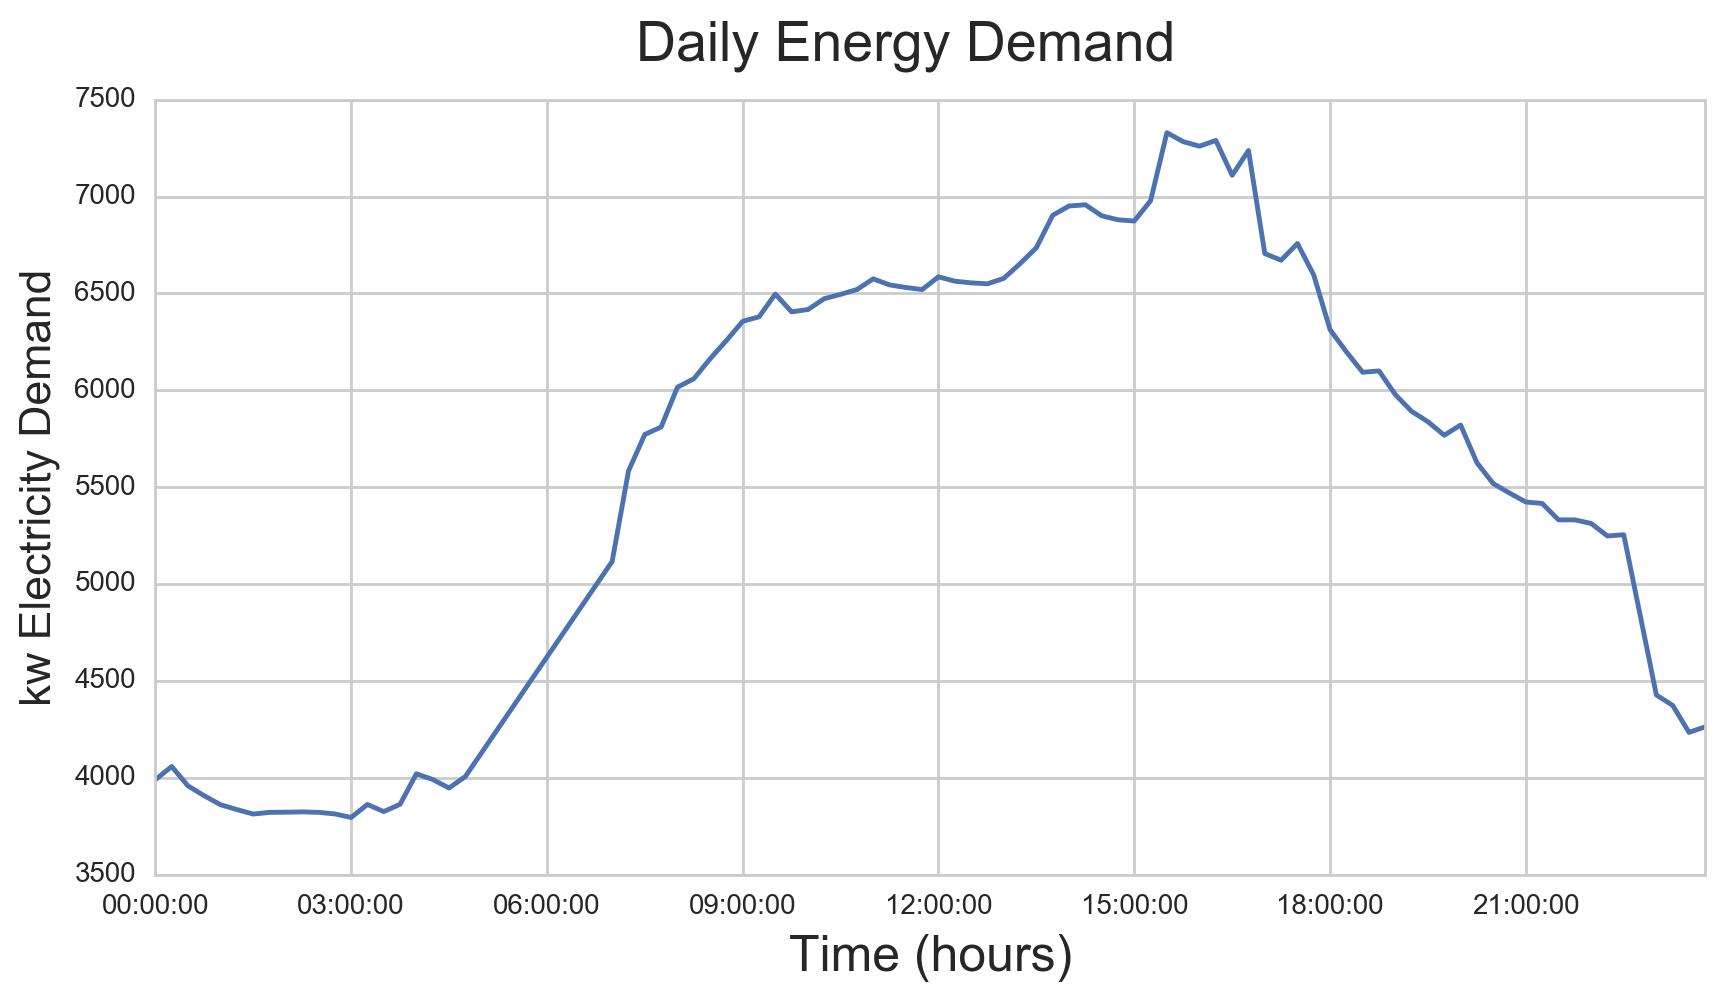

In [33]:
timestamp1 = pd.to_datetime('2014-04-22 00:00:00')
timestamp2 = pd.to_datetime('2014-04-23 00:00:00')

x=[]
y=[]

for i, row in building.iterrows():
    if building['time'][i] >= timestamp1 and building['time'][i] < timestamp2:
        x.append(building['time'][i])
        y.append(building['interval_value'][i])

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Daily Energy Demand', fontsize=20)
plt.xlabel('Time (hours)', fontsize=18)
plt.ylabel('kw Electricity Demand', fontsize=16)
plt.plot(x,y)

Plot a weeks worth of the building's energy demand to see if there is a pattern.

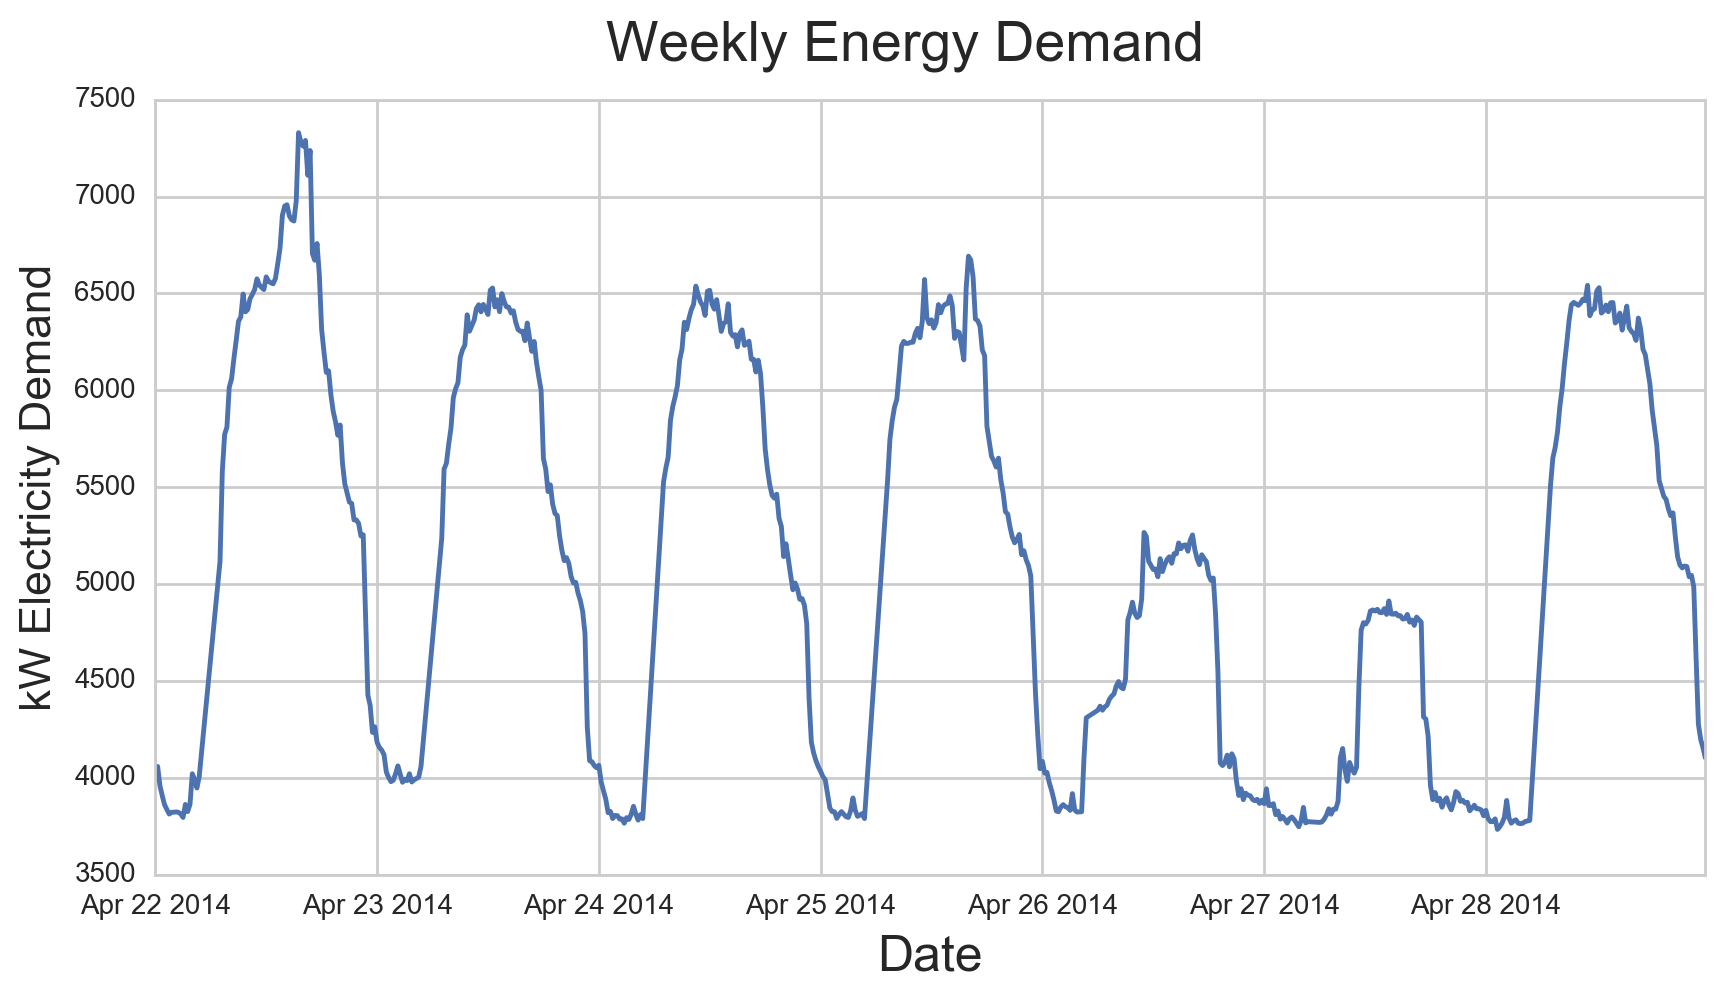

In [34]:
timestamp3 = pd.to_datetime('2014-04-22 00:00:00')
timestamp4 = pd.to_datetime('2014-04-29 00:00:00')

a = []
b = []

for i, row in building.iterrows():
    if building['time'][i] >= timestamp3 and building['time'][i] < timestamp4:
        a.append(building['time'][i])
        b.append(building['interval_value'][i])

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Weekly Energy Demand', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('kW Electricity Demand', fontsize=16)
plt.plot(a,b)

The two days with peaks that have half the size of the others are the weekends. The first day in this graph has an energy peak higher than the other days. This could be an anomaly.

I'm going to try and replicate the previous chart by bootstrapping it to see whether this process can create something similar.

First I'm creating a function to bootstrap the data and another to studentize it.

In [11]:
def bootstrap(sample, stat_func, iters):
    boots = []
    for i in range(iters):
        boot_sample = np.random.choice(sample, size = len(sample))
        statistic = stat_func(boot_sample)
        boots.append(statistic)
    return boots

def studentize(data):
    mean = np.mean(data)
    std = np.std(data)
    ts = (data - mean) / std
    
    return ts

Plot bootstrapped data over same time period.

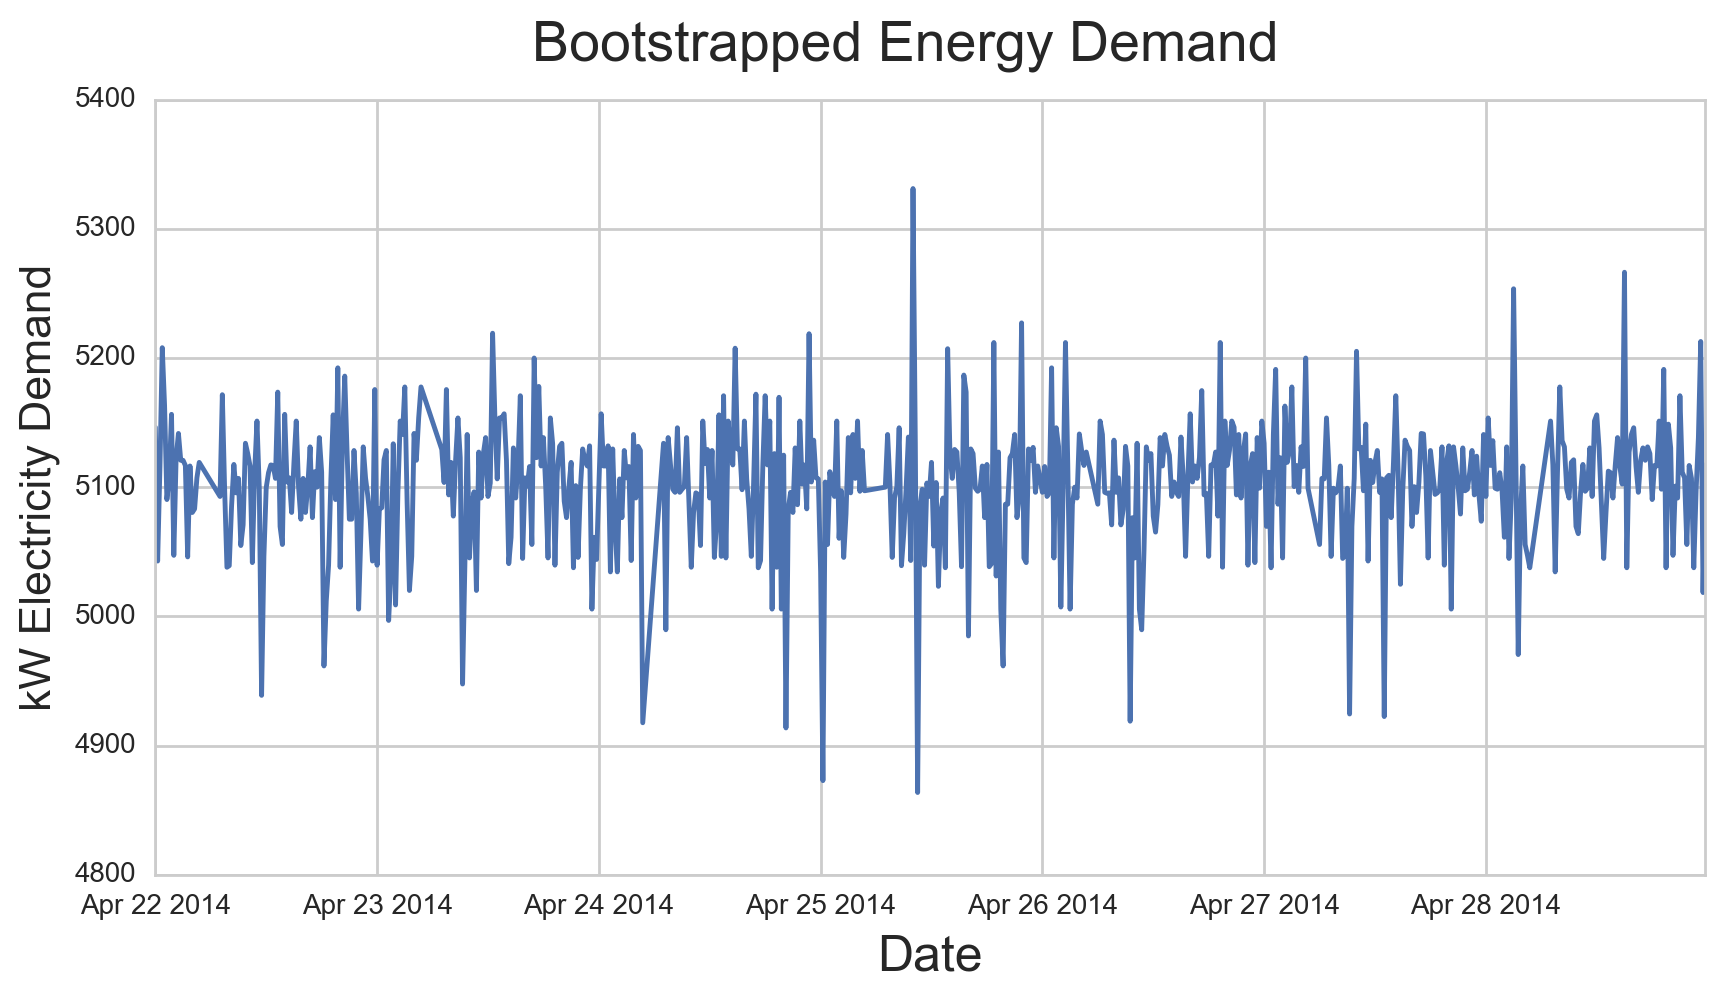

In [35]:
b_boot = bootstrap(b, np.median, len(b))

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Bootstrapped Energy Demand', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('kW Electricity Demand', fontsize=16)
plt.plot(a, b_boot)

The bootstrapped data is not creating nor maintaining the typical building demand curves. It is randomly shuffling all collected data points across the given time period.

Since this is a timeseries problem, it looks like regular bootstrapping is not the right approach for creating building energy demand curves. 

I'm now going to apply a circular block bootstrap on the same data. Circular block bootstrapping takes into account the timeseries nature of my data and takes random smaller sized time blocks and shuffles them around.

This first try I'm using a day as the shuffled timeblock.

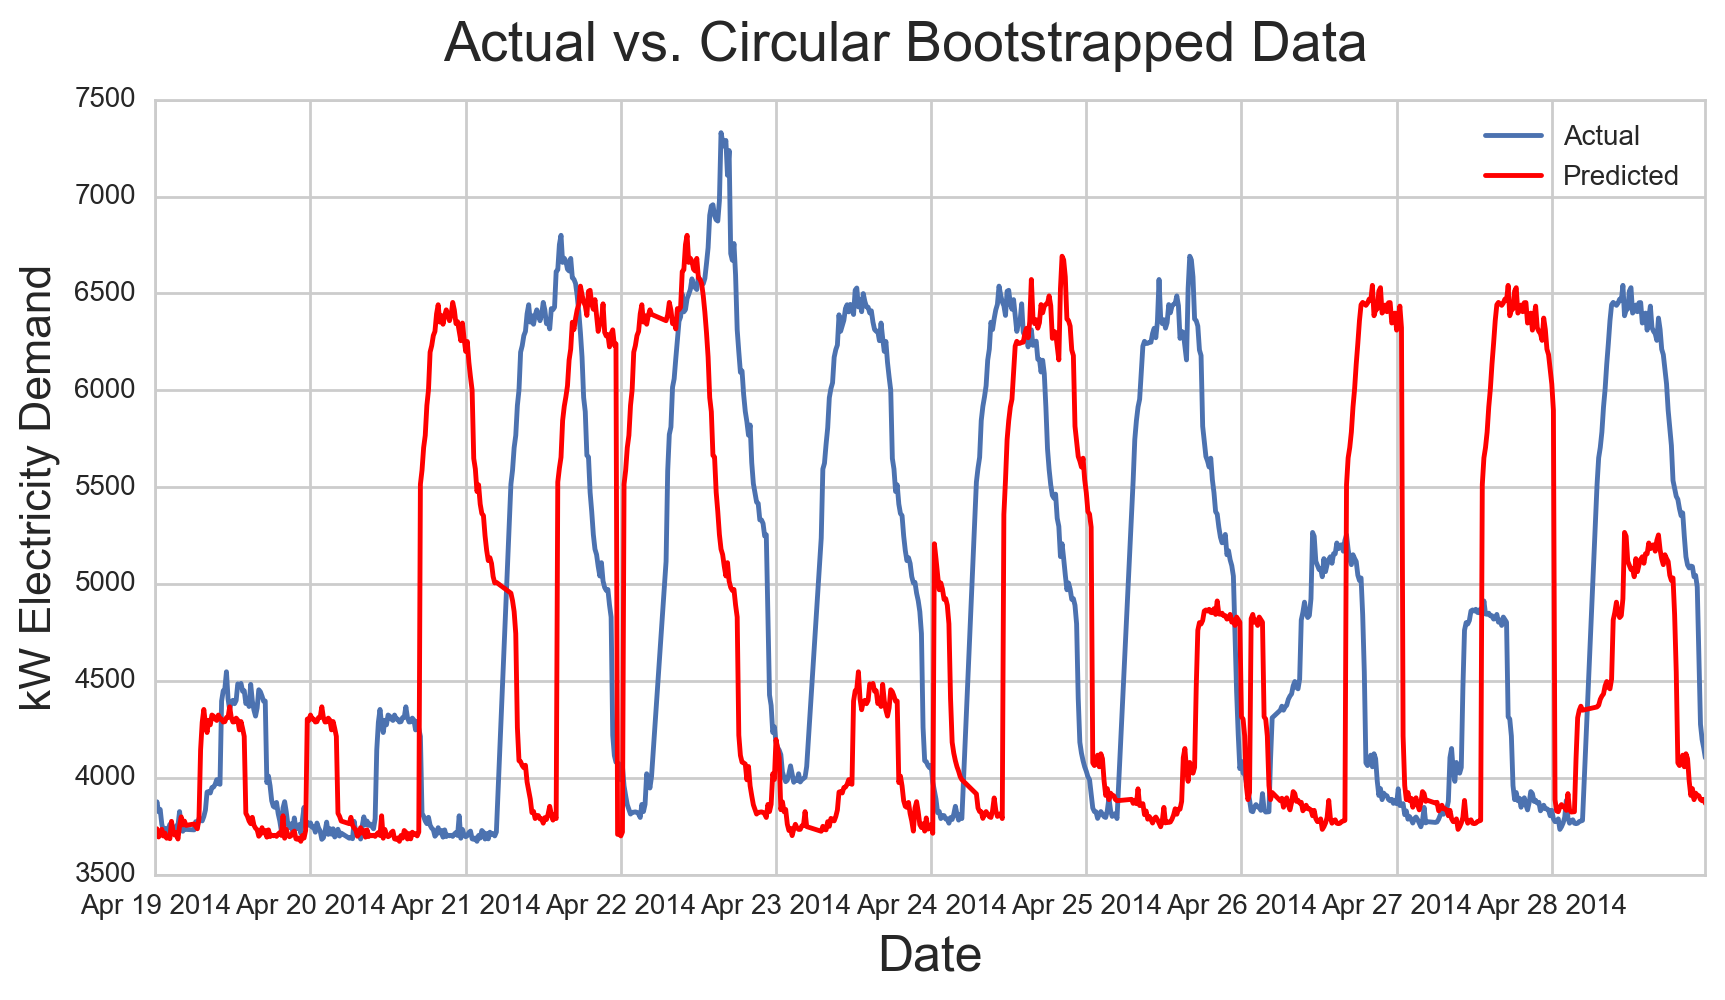

In [36]:
block_a = []
time_block = []
block_boot_a = []

for i, row in building.iterrows():
    if building['days_total'][i] <= 16:
        block_a.append(building['interval_value'][i])
        time_block.append(building['time'][i])
        block_boot_a.append(building['interval_value'][i])
        circboot = CircularBlockBootstrap(90, np.array(block_a))
        for data in circboot.bootstrap(100):
            new_block = data[0][0]
    else:
        pass
    
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Actual vs. Circular Bootstrapped Data', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('kW Electricity Demand', fontsize=16)
plt.plot(time_block, block_boot_a)
plt.plot(time_block, new_block, color = 'red')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

Trying a smaller timeblock.

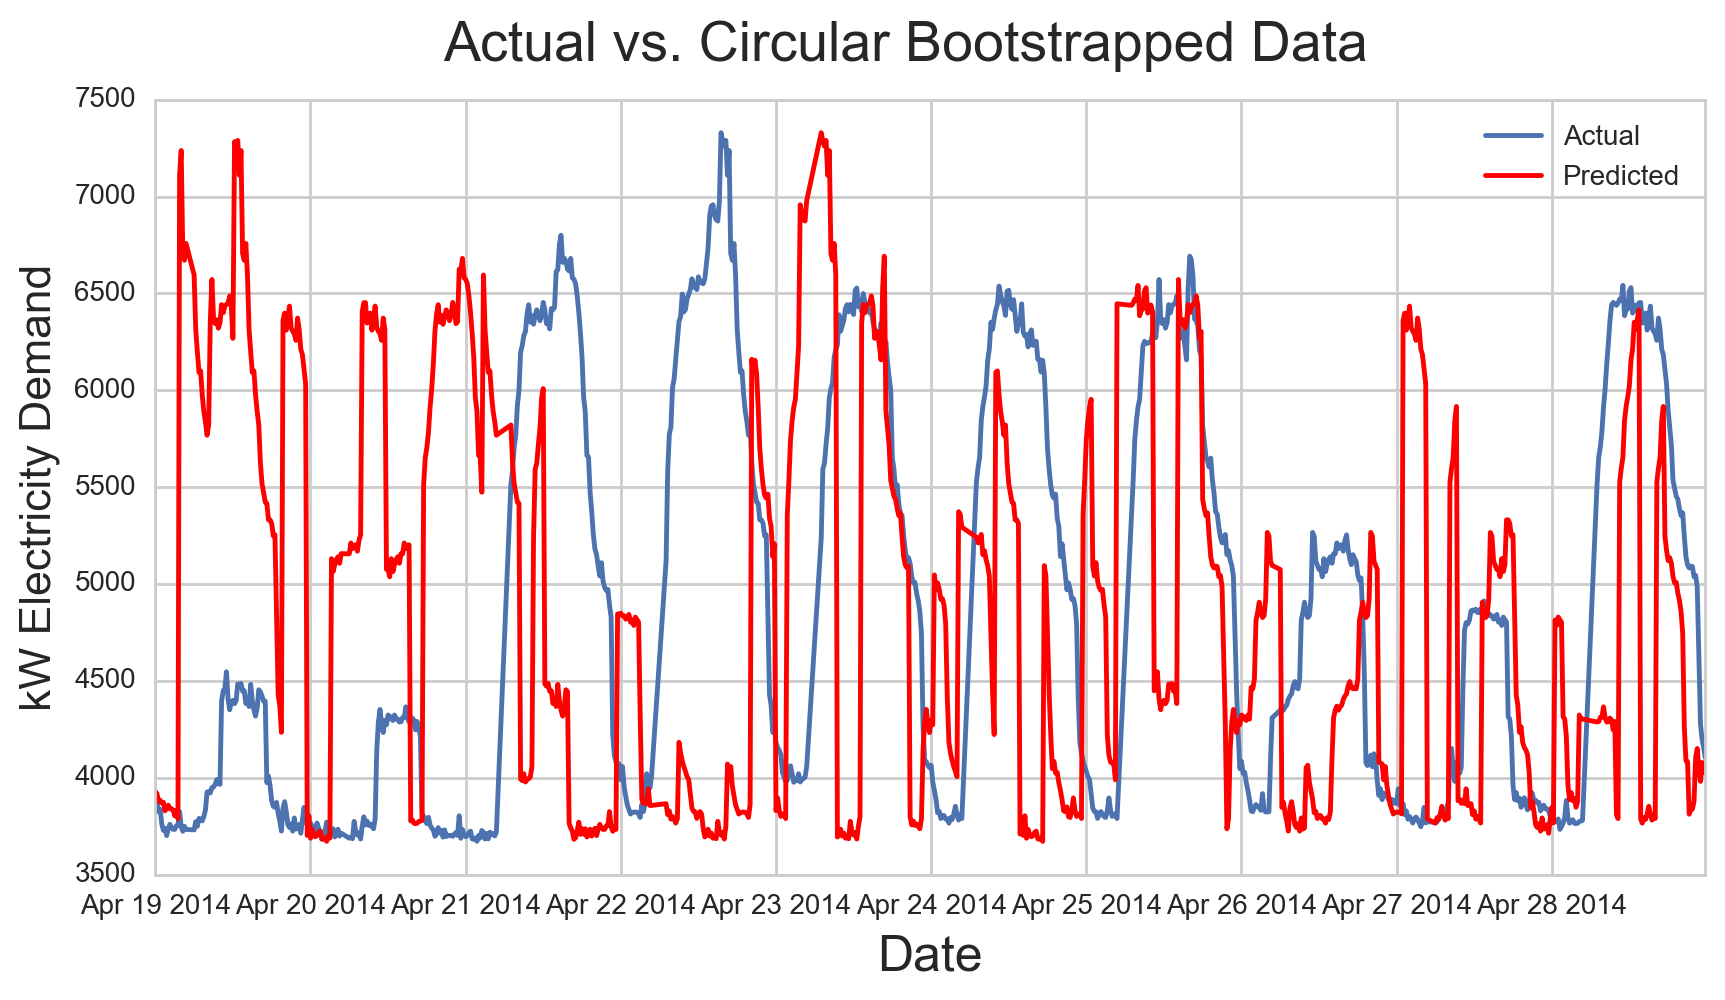

In [37]:
block_a = []
time_block = []
block_boot_a = []

for i, row in building.iterrows():
    if building['days_total'][i] <= 16:
        block_a.append(building['interval_value'][i])
        time_block.append(building['time'][i])
        block_boot_a.append(building['interval_value'][i])
        circboot = CircularBlockBootstrap(15, np.array(block_a))
        for data in circboot.bootstrap(100):
            new_block = data[0][0]
    else:
        pass
    
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Actual vs. Circular Bootstrapped Data', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('kW Electricity Demand', fontsize=16)
plt.plot(time_block, block_boot_a)
plt.plot(time_block, new_block, color = 'red')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

Since multiple versions of bootstrapping weren’t producing reliable baselines for a building’s electricity demand, I decided to move on to different machine learning techniques.

Will try the ARIMA method with this data to see if it can take past values of the interval_value variable and make accurate forecasts. Will try a train/test split of 0.5/0.5 and 0.25/0.75.

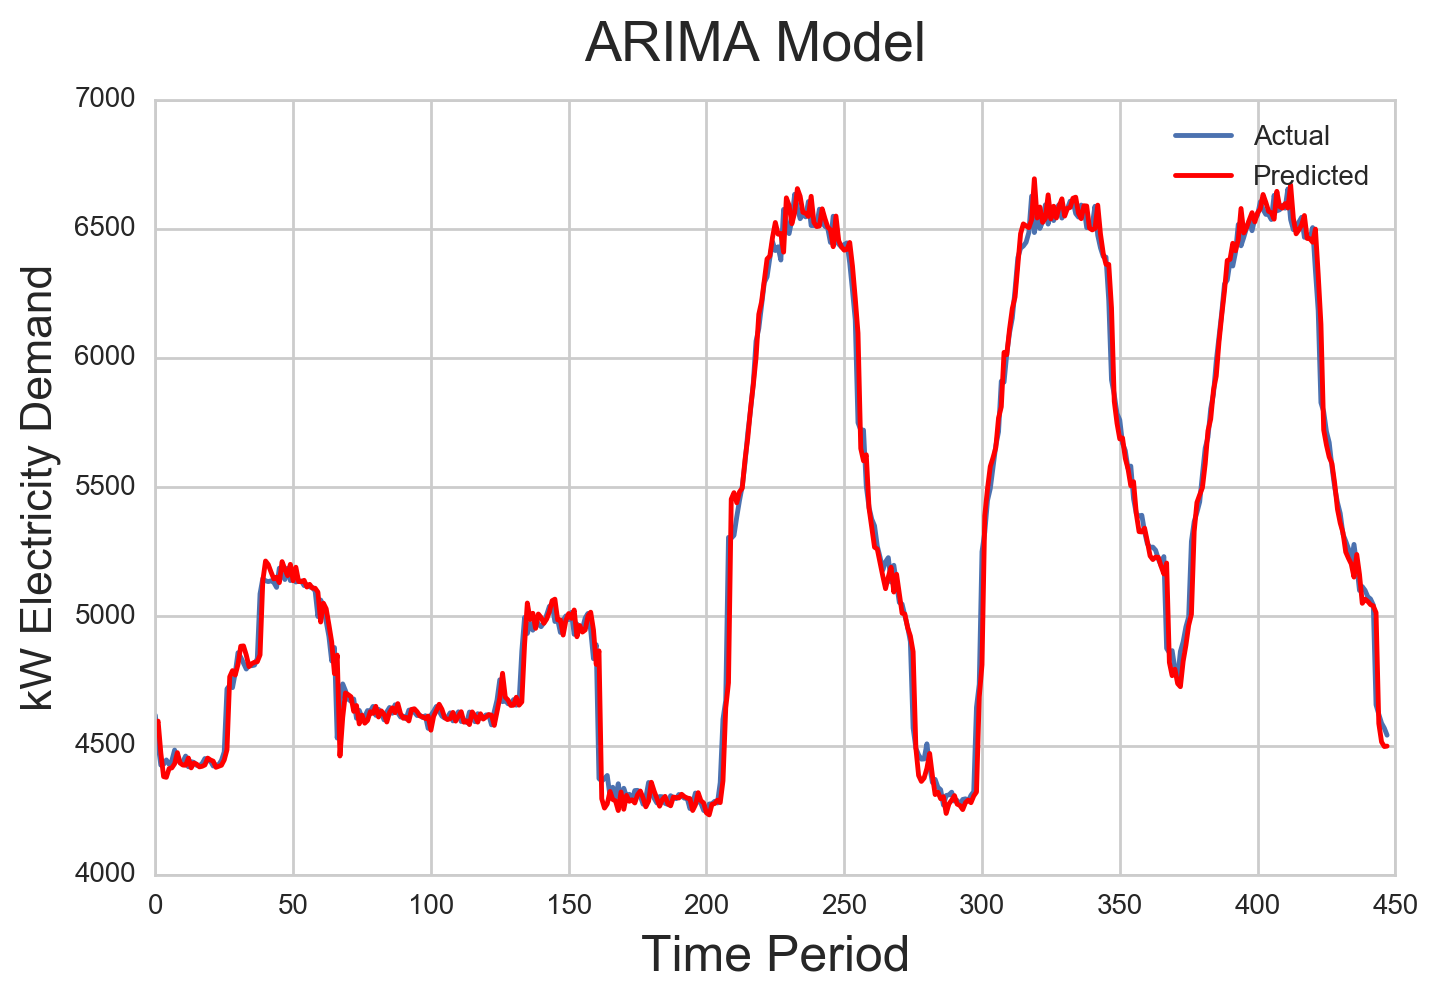

In [40]:
timestamp_a = pd.to_datetime('2015-1-05 00:00:00')
timestamp_b = pd.to_datetime('2015-1-15 00:00:00')

energy_curve1 = []
time_len1 = []

for i, row in building.iterrows():
    if building['time'][i] >= timestamp_a and building['time'][i] < timestamp_b:
        time_len1.append(building['time'][i])
        energy_curve1.append(building['interval_value'][i])              
        
size = int(len(energy_curve1) * 0.5)
train = energy_curve1[0:size]
test = energy_curve1[size:len(energy_curve1)]
hist = [x for x in train]
predictions1 = list()

for item in range(len(test)):
    model = ARIMA(hist, order=(5,2,1))
    model_fit = model.fit(disp=0, solver='nm')
    output = model_fit.forecast()
    y_hat = output[0]
    predictions1.append(y_hat)
    obsv = test[item]
    hist.append(obsv)

#Overlapped Plot of actual and predicted plots over an arbitrary time interval
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle('ARIMA Model', fontsize=20)
plt.xlabel('Time Period', fontsize=18)
plt.ylabel('kW Electricity Demand', fontsize=16)
plt.plot(test)
plt.plot(predictions1, color='red')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

Calculate the residuals to determine the accuracy of the ARIMA Model.

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   3.,   1.,   1.,   1.,   0.,   4.,   9.,
         11.,  34.,  45.,  66.,  89.,  67.,  40.,  24.,  18.,  11.,   5.,
          4.,   2.,   0.,   1.,   0.,   0.,   1.,   2.,   1.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-562.55456958, -541.41656252, -520.27855546, -499.1405484 ,
        -478.00254134, -456.86453428, -435.72652722, -414.58852016,
        -393.4505131 , -372.31250604, -351.17449898, -330.03649192,
        -308.89848486, -287.7604778 , -266.62247074, -245.48446368,
        -224.34645662, -203.20844956, -182.0704425 , -160.93243544,
        -139.79442838, -118.65642132,  -97.51841426,  -76.3804072 ,
         -55.24240014,  -34.10439308,  -12.96638602,    8.17162103,
          29.30962809,   50.44763515,   71.58564221,   92.72364927,
         113.86165633,  134.99966339,  156.13767045,  177.27567751,
         198.41368457,  219.55169163,  240.689

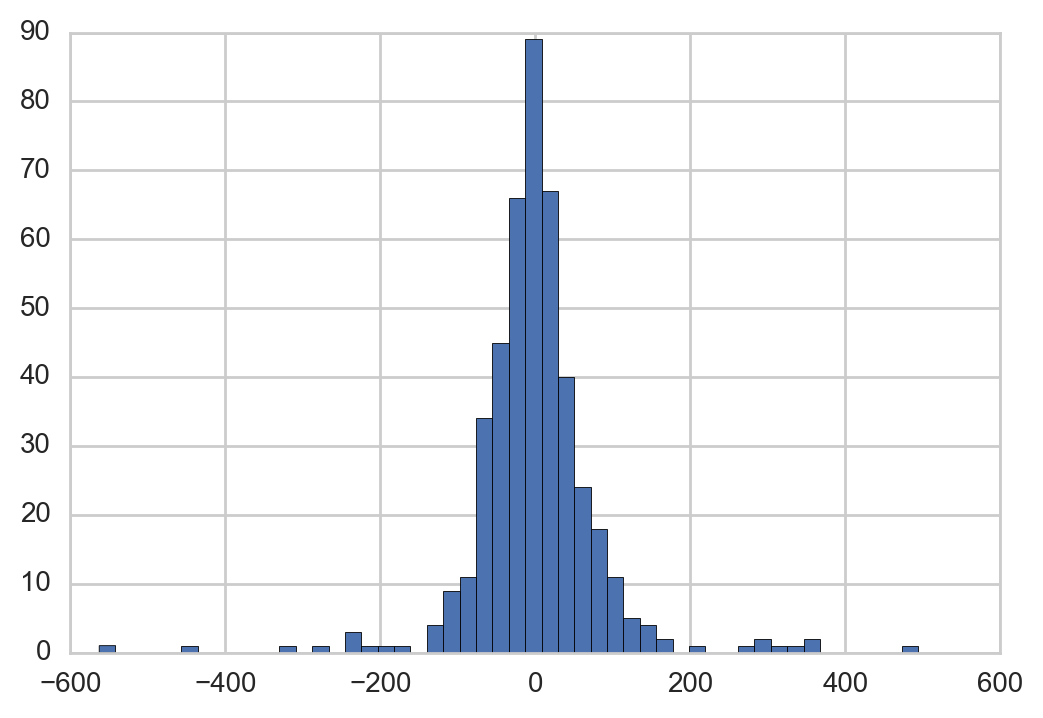

In [41]:
yhat = np.array(energy_curve1[-len(predictions1):])[:,np.newaxis]
y = np.array(predictions1)
residuals1 = y - yhat
plt.hist(residuals1, bins=50)

Studentize the residuals to get the the Z-scores of the residuals and plot them to see how off the worst predictions were.

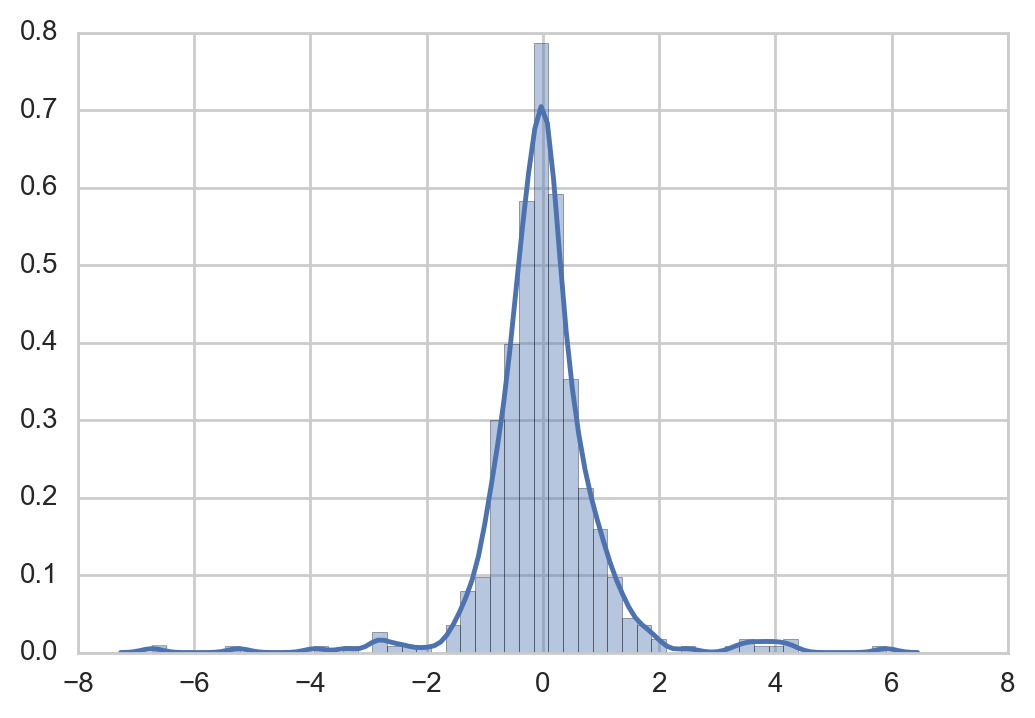

In [42]:
sns.distplot(studentize(residuals1))

A couple predictions were statistically off from the actual values.

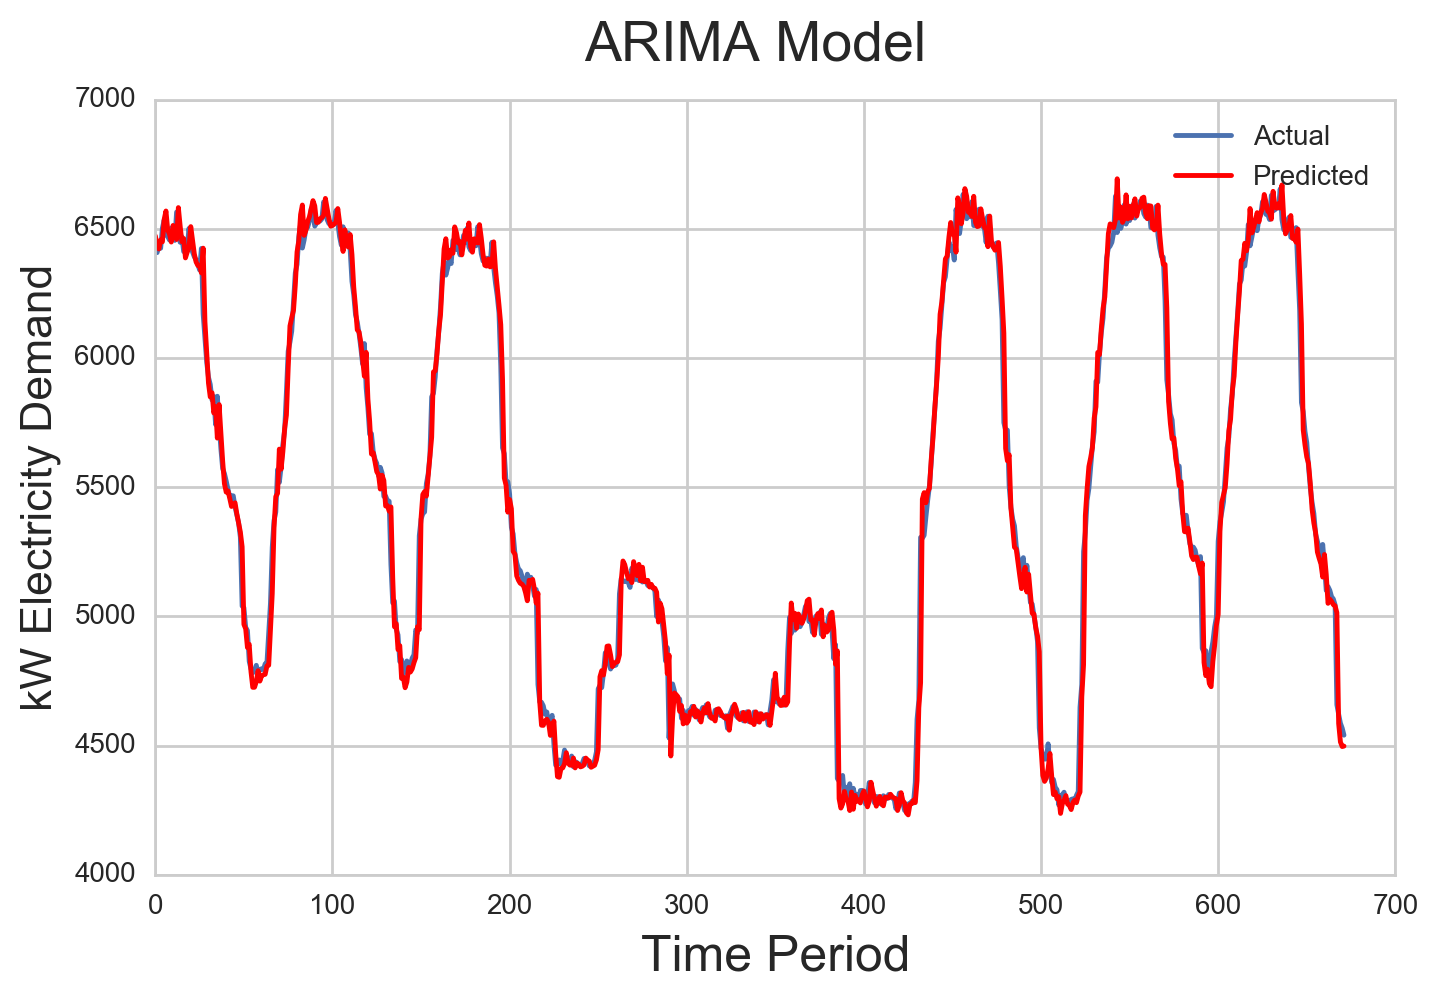

In [43]:
timestamp_a = pd.to_datetime('2015-1-05 00:00:00')
timestamp_b = pd.to_datetime('2015-1-15 00:00:00')

energy_curve2 = []
time_len2 = []

for i, row in building.iterrows():
    if building['time'][i] >= timestamp_a and building['time'][i] < timestamp_b:
        time_len2.append(building['time'][i])
        energy_curve2.append(building['interval_value'][i])              
        
size = int(len(energy_curve1) * 0.25)
train = energy_curve2[0:size]
test = energy_curve2[size:len(energy_curve1)]
hist = [x for x in train]
predictions2 = list()

for item in range(len(test)):
    model = ARIMA(hist, order=(5,2,1))
    model_fit = model.fit(disp=0, solver='nm')
    output = model_fit.forecast()
    y_hat = output[0]
    predictions2.append(y_hat)
    obsv = test[item]
    hist.append(obsv)

# Overlapped Plot of actual and predicted over an arbitrary time interval
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle('ARIMA Model', fontsize=20)
plt.xlabel('Time Period', fontsize=18)
plt.ylabel('kW Electricity Demand', fontsize=16)
plt.plot(test)
plt.plot(predictions2, color='red')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

(array([   1.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           1.,    0.,    1.,    0.,    1.,    0.,    3.,    1.,    1.,
           3.,    1.,    6.,   15.,   21.,   49.,   70.,   94.,  128.,
          96.,   60.,   48.,   26.,   15.,    6.,    6.,    4.,    0.,
           1.,    2.,    1.,    2.,    2.,    1.,    1.,    3.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([-562.55456958, -541.41656252, -520.27855546, -499.1405484 ,
        -478.00254134, -456.86453428, -435.72652722, -414.58852016,
        -393.4505131 , -372.31250604, -351.17449898, -330.03649192,
        -308.89848486, -287.7604778 , -266.62247074, -245.48446368,
        -224.34645662, -203.20844956, -182.0704425 , -160.93243544,
        -139.79442838, -118.65642132,  -97.51841426,  -76.3804072 ,
         -55.24240014,  -34.10439308,  -12.96638602,    8.17162103,
          29.30962809,   50.44763515,   71.58564221,   92.72364927,
         113.86165633,  134.99966339,  156.13767045,  17

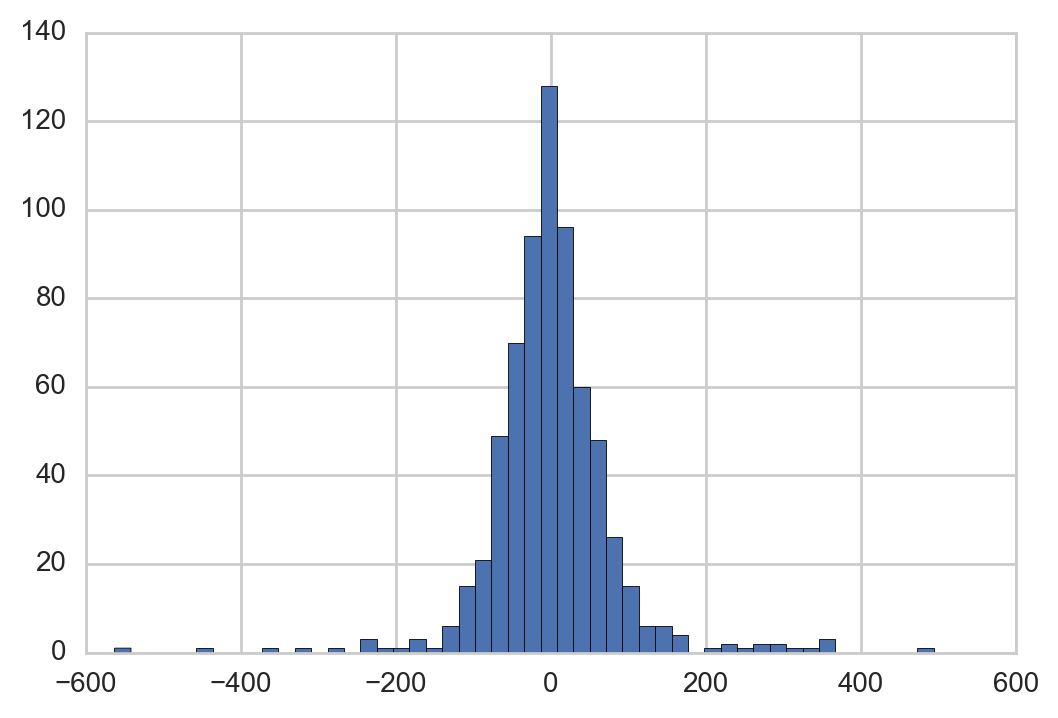

In [44]:
yhat = np.array(energy_curve2[-len(predictions2):])[:,np.newaxis]
y = np.array(predictions2)
residuals2 = y - yhat
plt.hist(residuals2, bins=50)

Find the percent error of the ARIMA model on the 0.25/0.75 train/test split (in percentage).

In [45]:
acc = []
for i, item in enumerate(test): 
    acc.append((((test[i] - predictions2[i]) / test) * 100))
    
acc_a = np.array(acc)
abs(acc_a.mean())

0.0074909512838171564

ARIMA has an uncertainty of around 0.01%

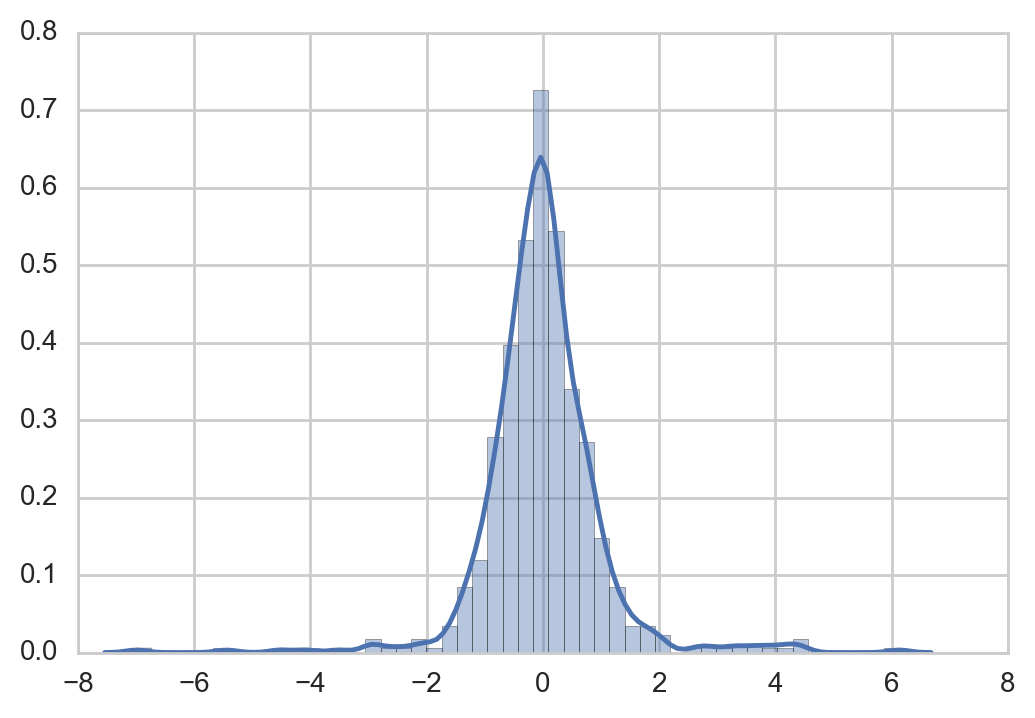

In [46]:
sns.distplot(studentize(residuals2))

Just looking at the results from both train/test split ARIMA models shows that it does a good job of forecasting the building's energy demand. The plots of the studentized residuals indicates that there are only a couple of points that are significant in their inaccuracies.

One limitation of ARIMA models is that they can only make forecasts using one variable. I want to make use of all the variables in the dataset to forecast the building's energy demand. So the next step is to implement models that make predictions using multiple variables. I decided on a Long Short-Term Memory (LSTM) neural network.

First I'm going to create a subset of my original datasetto test the LSTM on so I can minimize the computation time.

In [47]:
building2 = building[:10000]

Remove variables that won't be used for the LSTM.

In [48]:
remove = ['timestamp', 'normalized_interval_value', 'time', 
          'ocd_count', 'is_holiday', 'ocd10_25_2016', 'ocd7_24_2014']

for items in remove:
    del building2[items]
    
building2.columns

Index([u'interval_value', u'apr', u'aug', u'cdd', u'dec', u'feb', u'hdd',
       u'holiday', u'humidity', u'jul', u'jun', u'mar', u'may', u'next_temp',
       u'nov', u'oct', u'prev_max_temp', u'prev_min_temp', u'sep', u'sky',
       u'tod15', u'tod30', u'tod45', u'year', u'month', u'day', u'hour',
       u'minute', u'dow', u'days_total', u'is_weekend'],
      dtype='object')

In [49]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
np.random.seed(5)

# properly define the parameters of the dataset
dataframe = building2
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the entire dataset using MinMaxScaler betweeon 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:] 
test = dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 25
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# fit the data using the LSTM network
model = Sequential()
model.add(LSTM(70, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#print model.summary()
model.fit(trainX, trainY, epochs=10, batch_size=1, validation_data=(testX, testY), verbose=2)

# make predictions based off of the trained data
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Train on 4974 samples, validate on 4974 samples
Epoch 1/10
49s - loss: 0.0052 - val_loss: 0.0032
Epoch 2/10
47s - loss: 0.0028 - val_loss: 0.0027
Epoch 3/10
48s - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
49s - loss: 0.0025 - val_loss: 0.0025
Epoch 5/10
50s - loss: 0.0025 - val_loss: 0.0028
Epoch 6/10
49s - loss: 0.0024 - val_loss: 0.0028
Epoch 7/10
49s - loss: 0.0024 - val_loss: 0.0026
Epoch 8/10
50s - loss: 0.0024 - val_loss: 0.0026
Epoch 9/10
49s - loss: 0.0023 - val_loss: 0.0031
Epoch 10/10
50s - loss: 0.0023 - val_loss: 0.0031


Plot increments of the LSTM results.

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


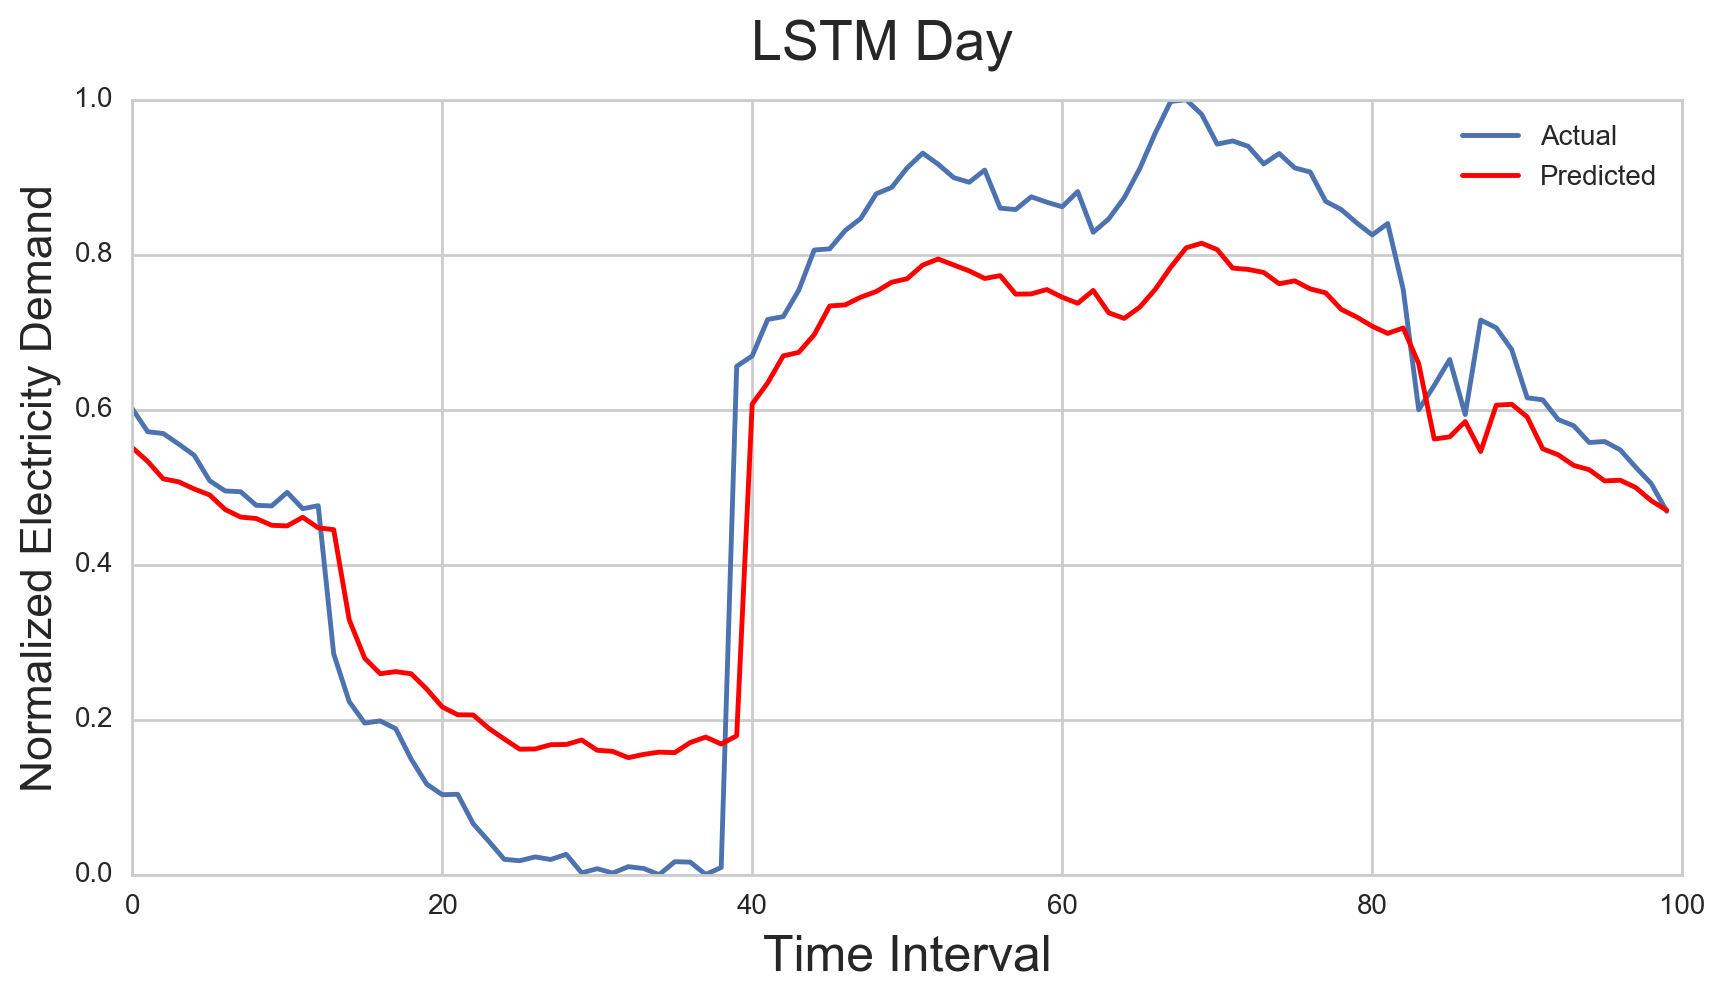

In [50]:
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(scaler.fit_transform(testY[1100:1200]))
plt.plot(testPredict[1100:1200], color='red')
fig.suptitle('LSTM Day', fontsize=20)
plt.xlabel('Time Interval', fontsize=18)
plt.ylabel('Normalized Electricity Demand', fontsize=16)
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


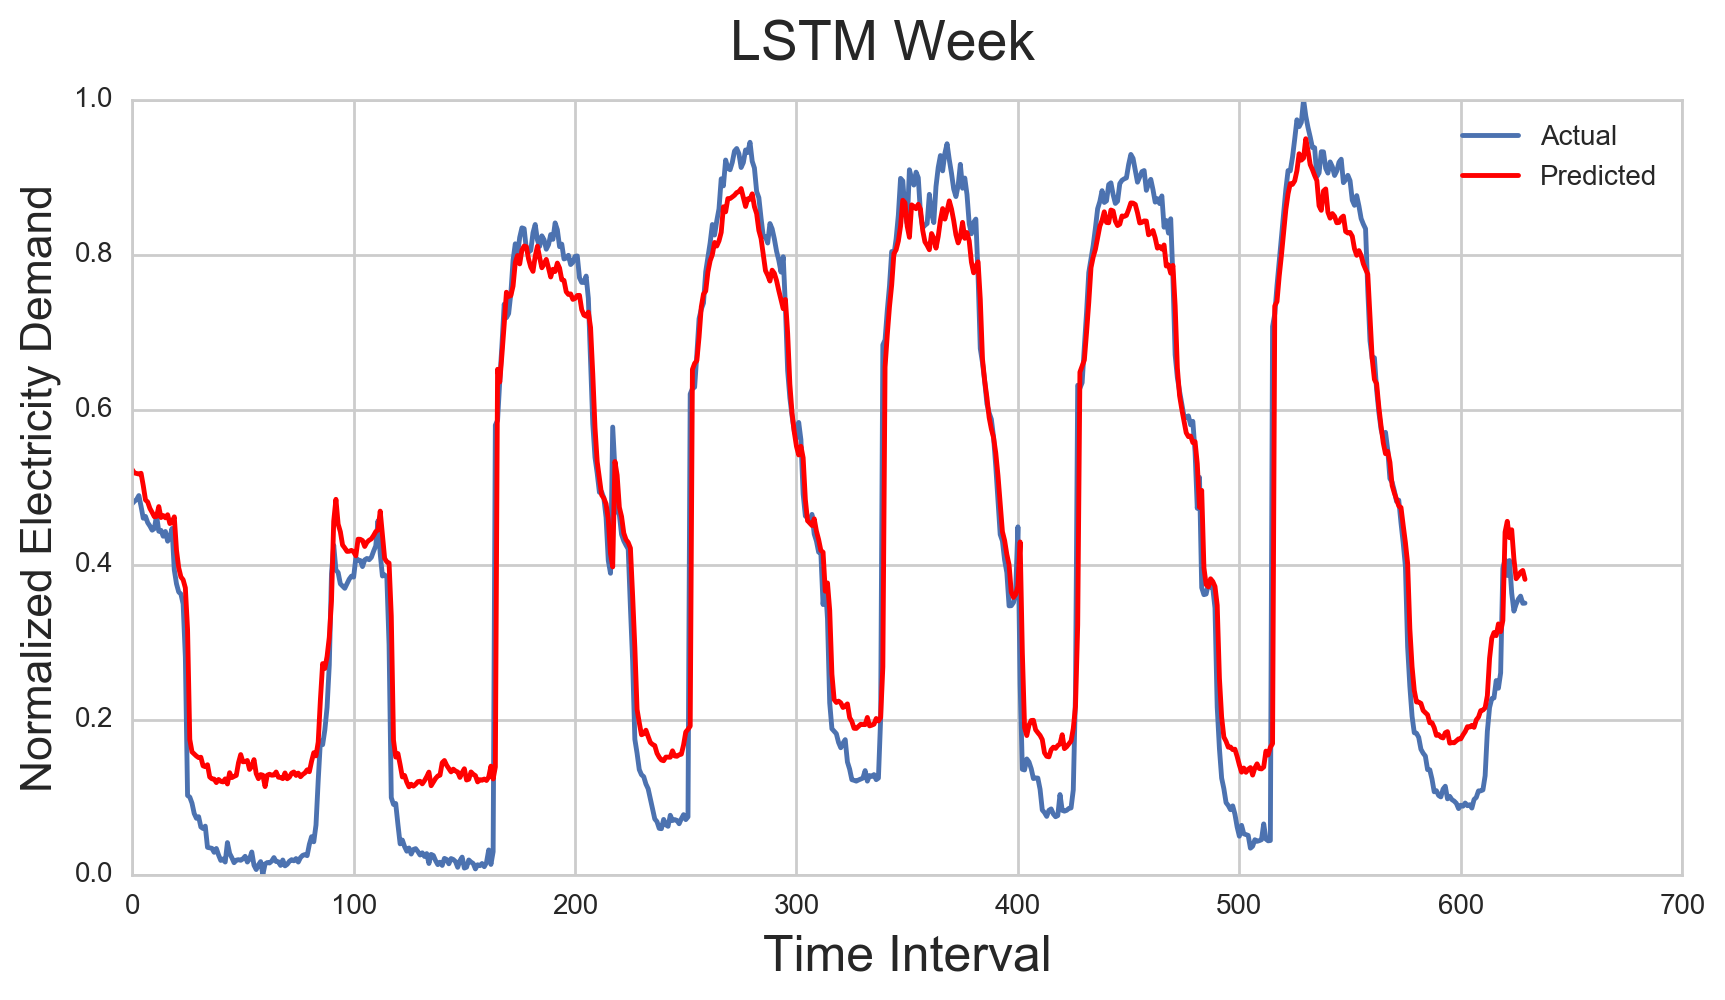

In [51]:
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(scaler.fit_transform(testY[:630]))
plt.plot(testPredict[:630], color='red')
fig.suptitle('LSTM Week', fontsize=20)
plt.xlabel('Time Interval', fontsize=18)
plt.ylabel('Normalized Electricity Demand', fontsize=16)
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


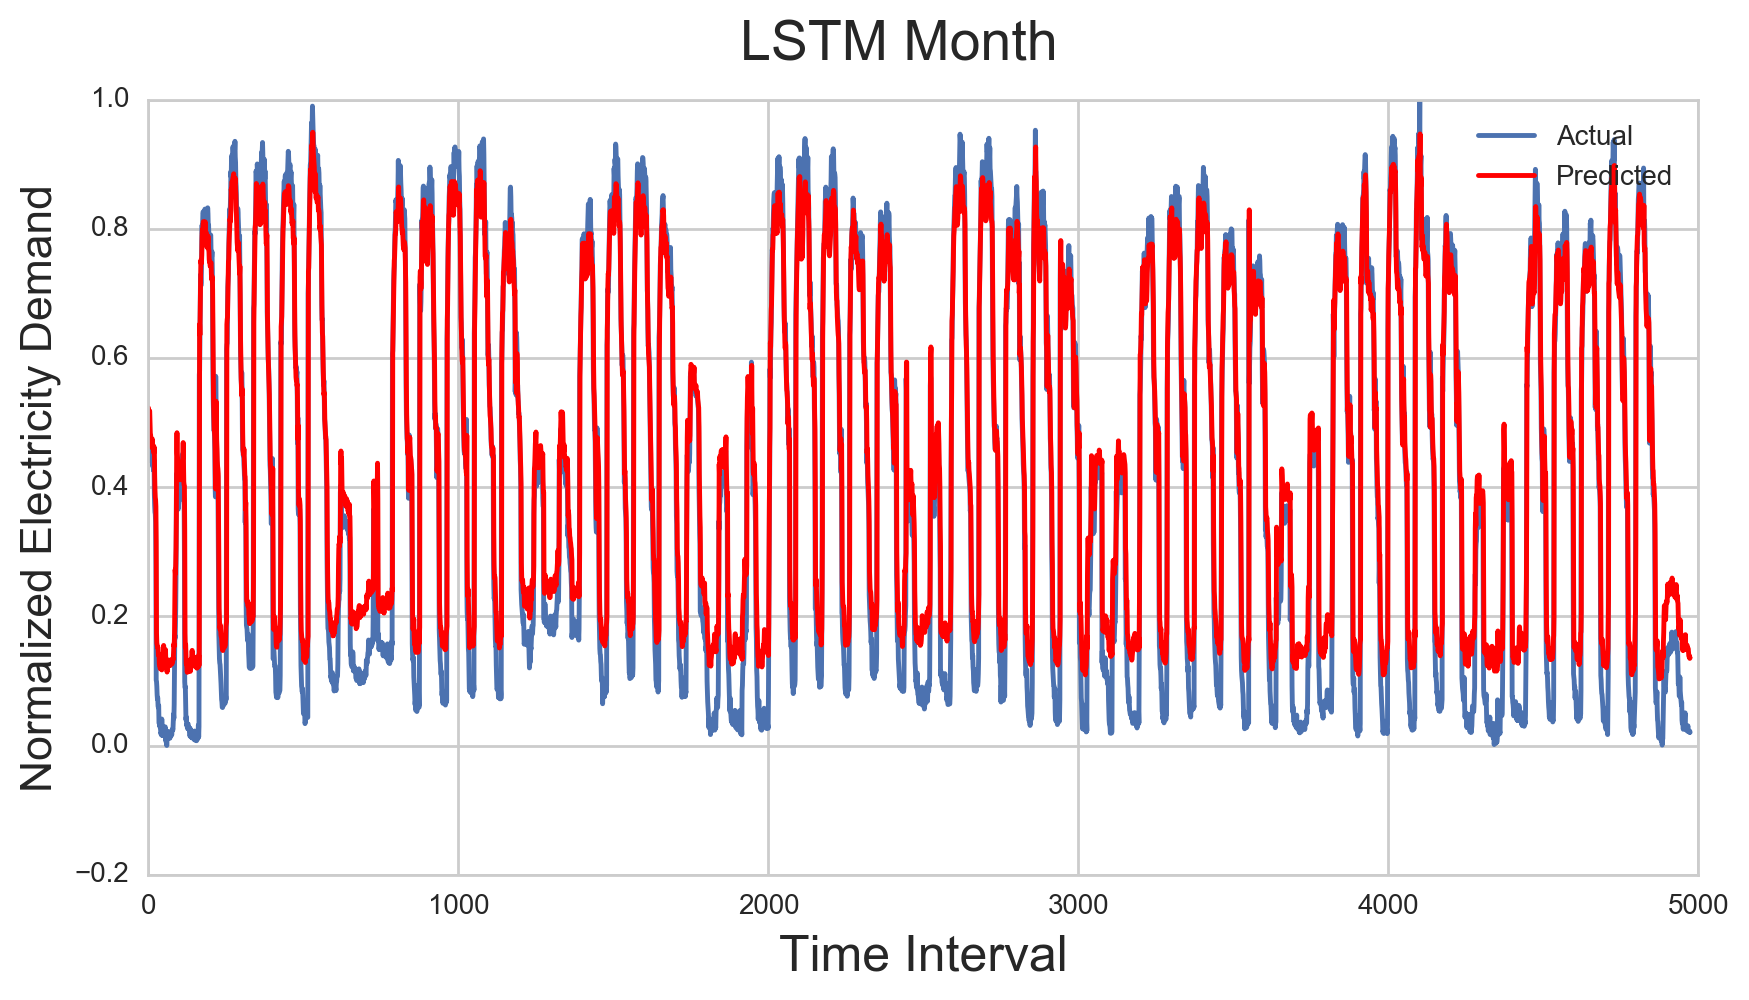

In [52]:
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(scaler.fit_transform(testY[:]))
plt.plot(testPredict[:], color='red')
fig.suptitle('LSTM Month', fontsize=20)
plt.xlabel('Time Interval', fontsize=18)
plt.ylabel('Normalized Electricity Demand', fontsize=16)
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

# LSTM Stateful Model 

Try a Stateful LSTM, which allows me to “reset” and define a time series and input each time step individually in the LSTM. At the end of each time step I restart the LSTM.

In [53]:
def create_dataset2(data, look_back=5, y_size=1):
    dataX, dataY = [], []
    for i in range(data.shape[0]-look_back-y_size):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back:i + look_back + y_size, 0])
    return np.array(dataX), np.array(dataY)

np.random.seed(5)

dataframe = building2
dataset = dataframe.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:] 
test = dataset[train_size:len(dataset),:]

look_back = 25
y_size = 15
trainX, trainY = create_dataset2(train, look_back, y_size=y_size)
testX, testY = create_dataset2(test, look_back, y_size=y_size)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 20
model = Sequential()
model.add(LSTM(140,
               return_sequences=True, 
               batch_input_shape=(batch_size, look_back, 1), 
               stateful=True))
model.add(LSTM(120, stateful=True))
model.add(Dense(y_size))
model.compile(loss='mean_squared_error', optimizer='adam')

# # invert predictions for RMSE calculations
# trainPredict4 = scaler.inverse_transform(trainPredict3)
# trainY_2 = scaler.inverse_transform([trainY])
# testPredict4 = scaler.inverse_transform(testPredict3)
# testY_2 = scaler.inverse_transform([testY])

for i in range(10):
    model.fit(trainX, trainY, nb_epoch=1, 
              validation_data=(testX, testY), batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()
       
trainPredict3 = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict3 = model.predict(testX, batch_size=batch_size)
model.reset_states()
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict3[:,0]))

# find the RMSE
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict3[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train on 6960 samples, validate on 2960 samples
Epoch 1/1
6960/6960 [==============================] - 51s - loss: 0.0460 - val_loss: 0.0366

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


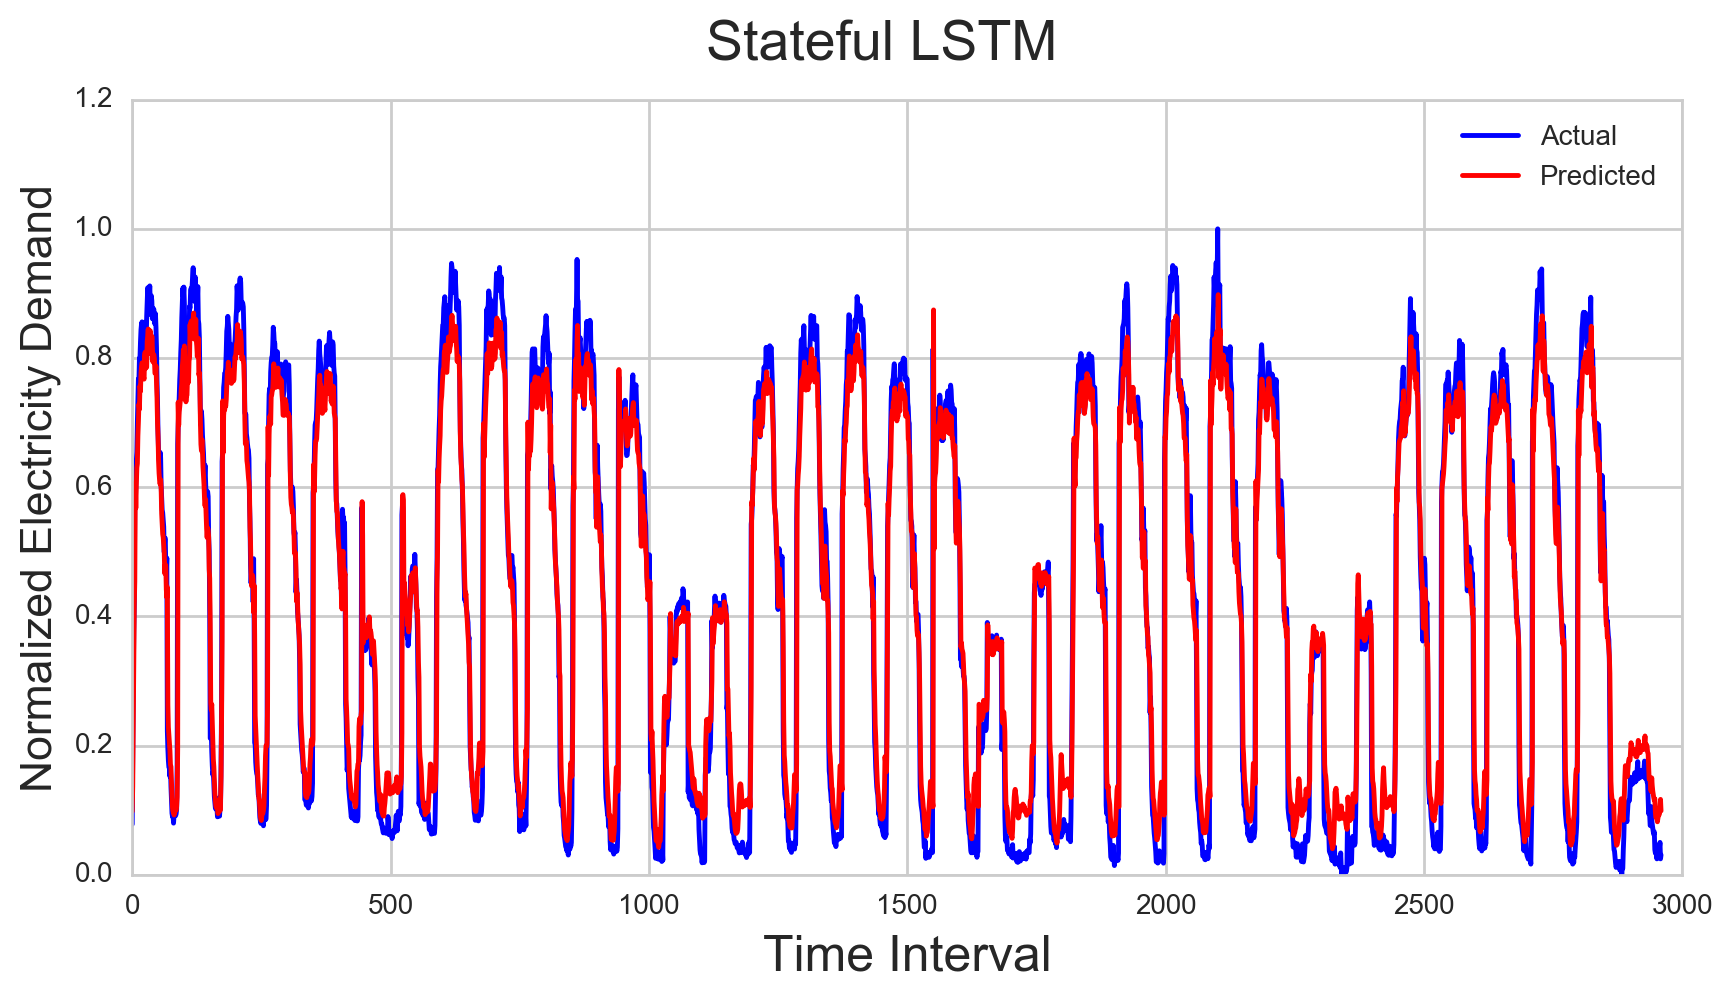

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


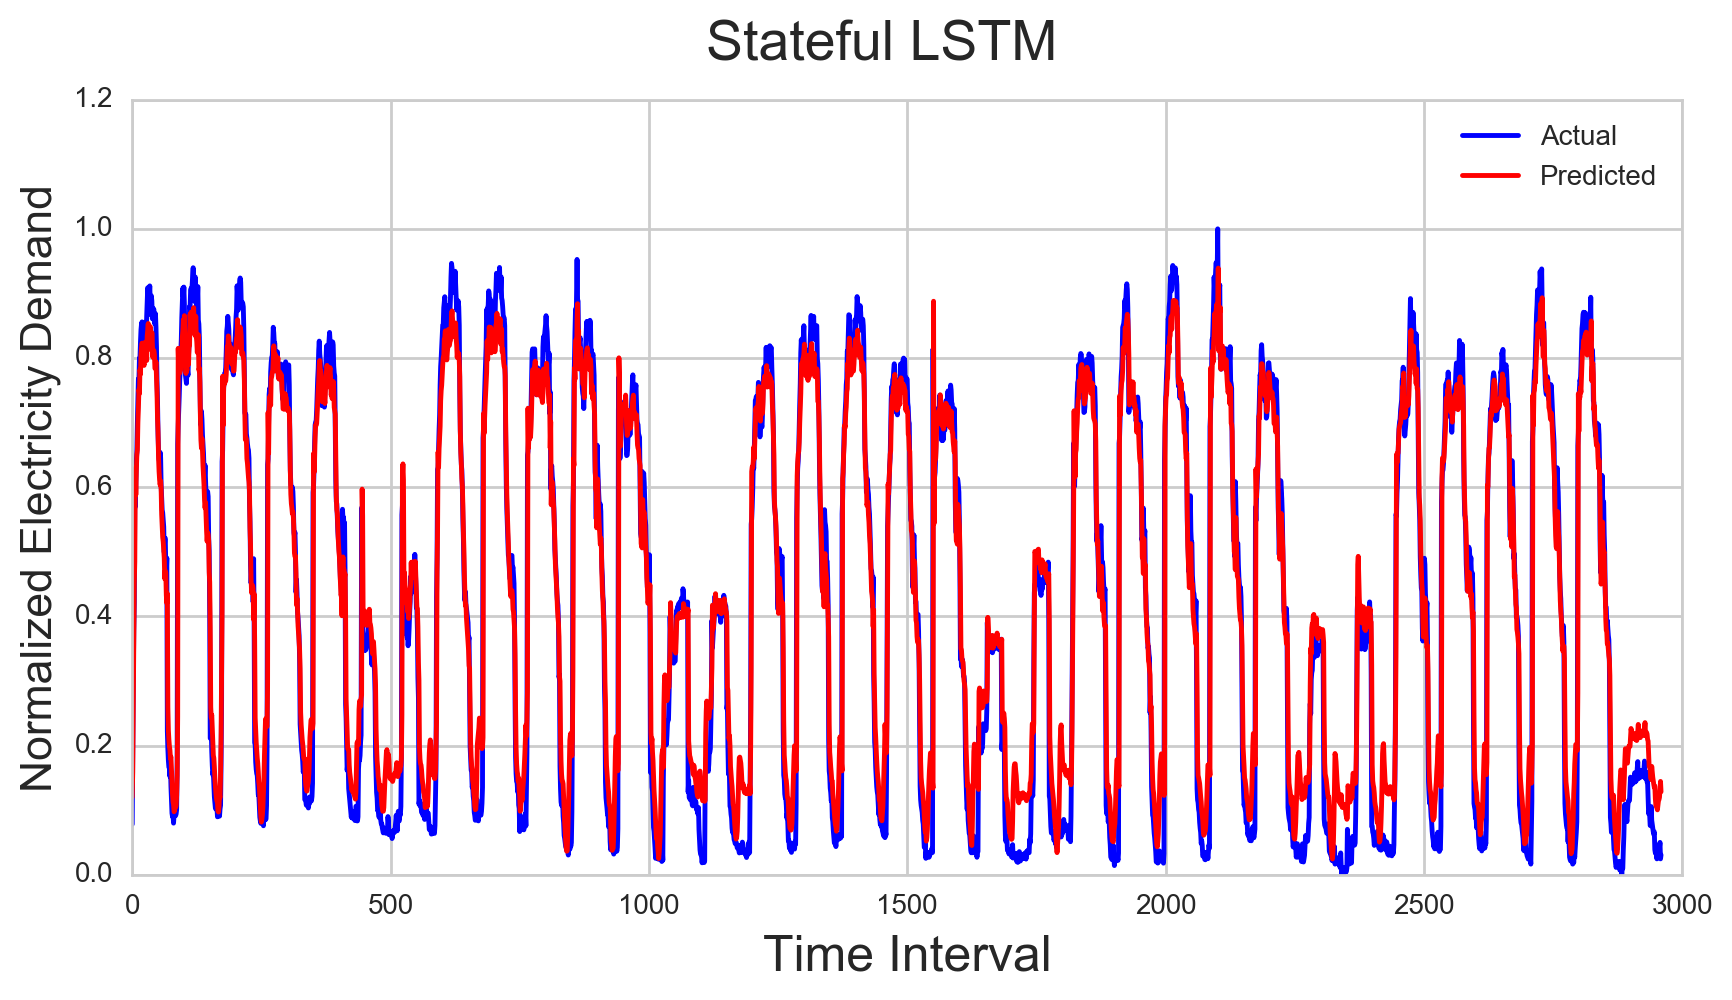

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


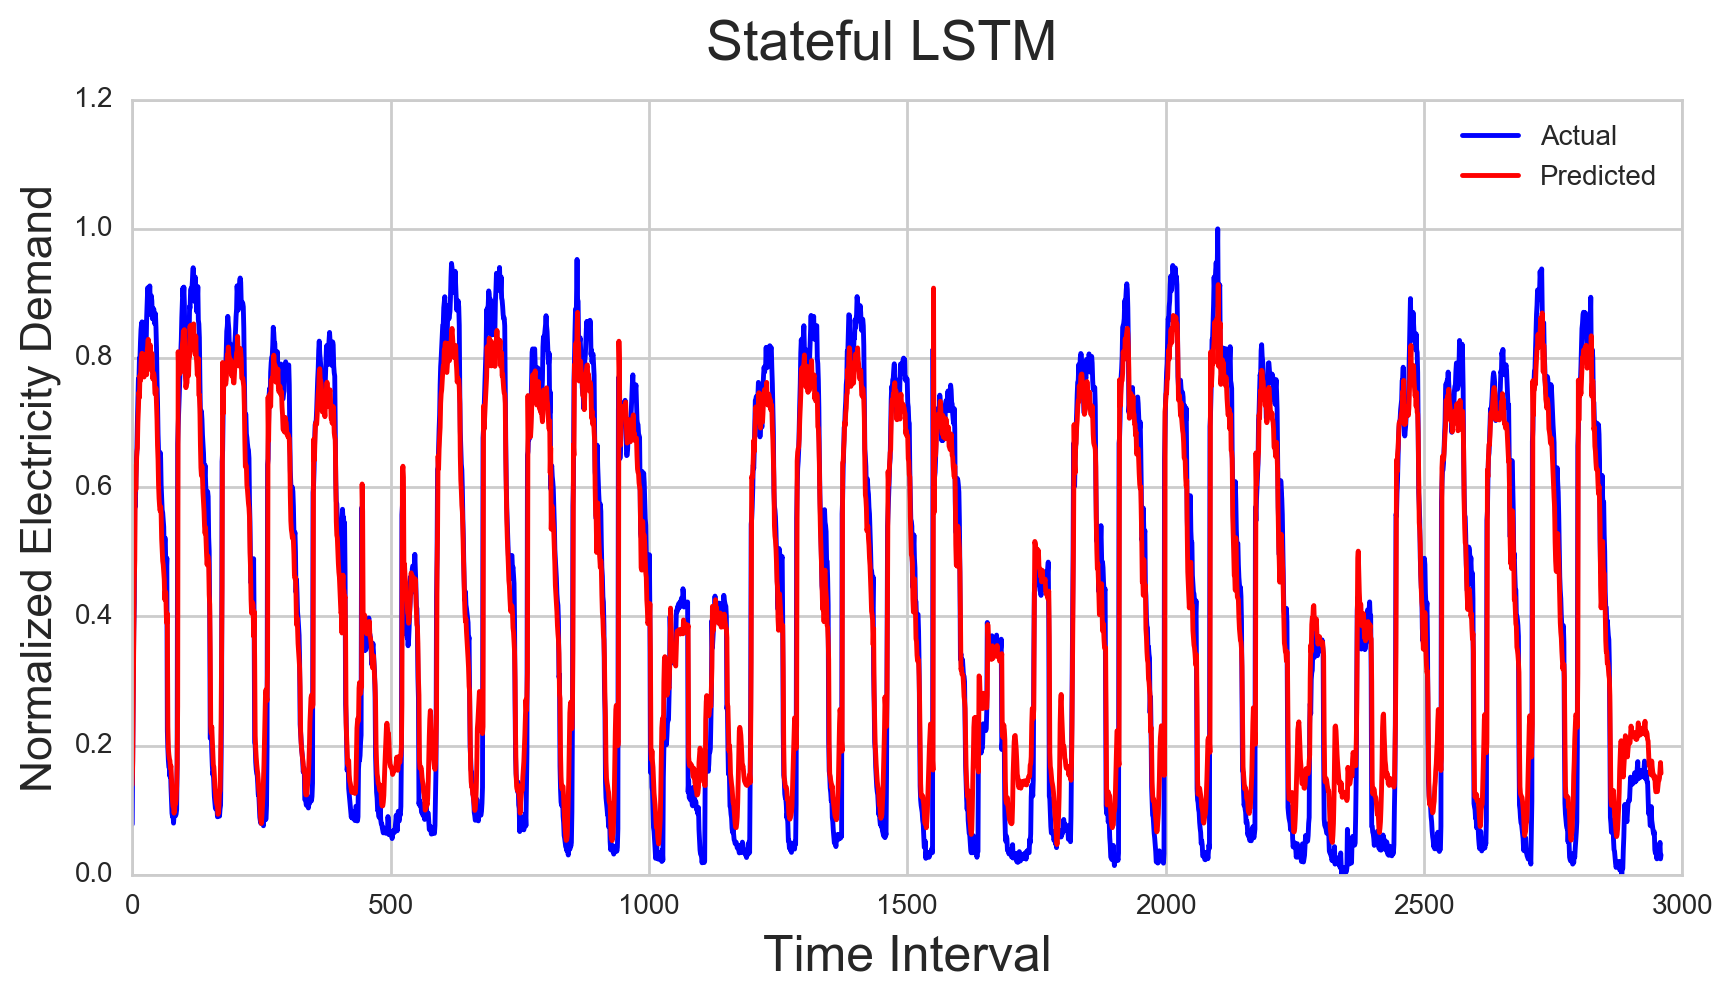

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


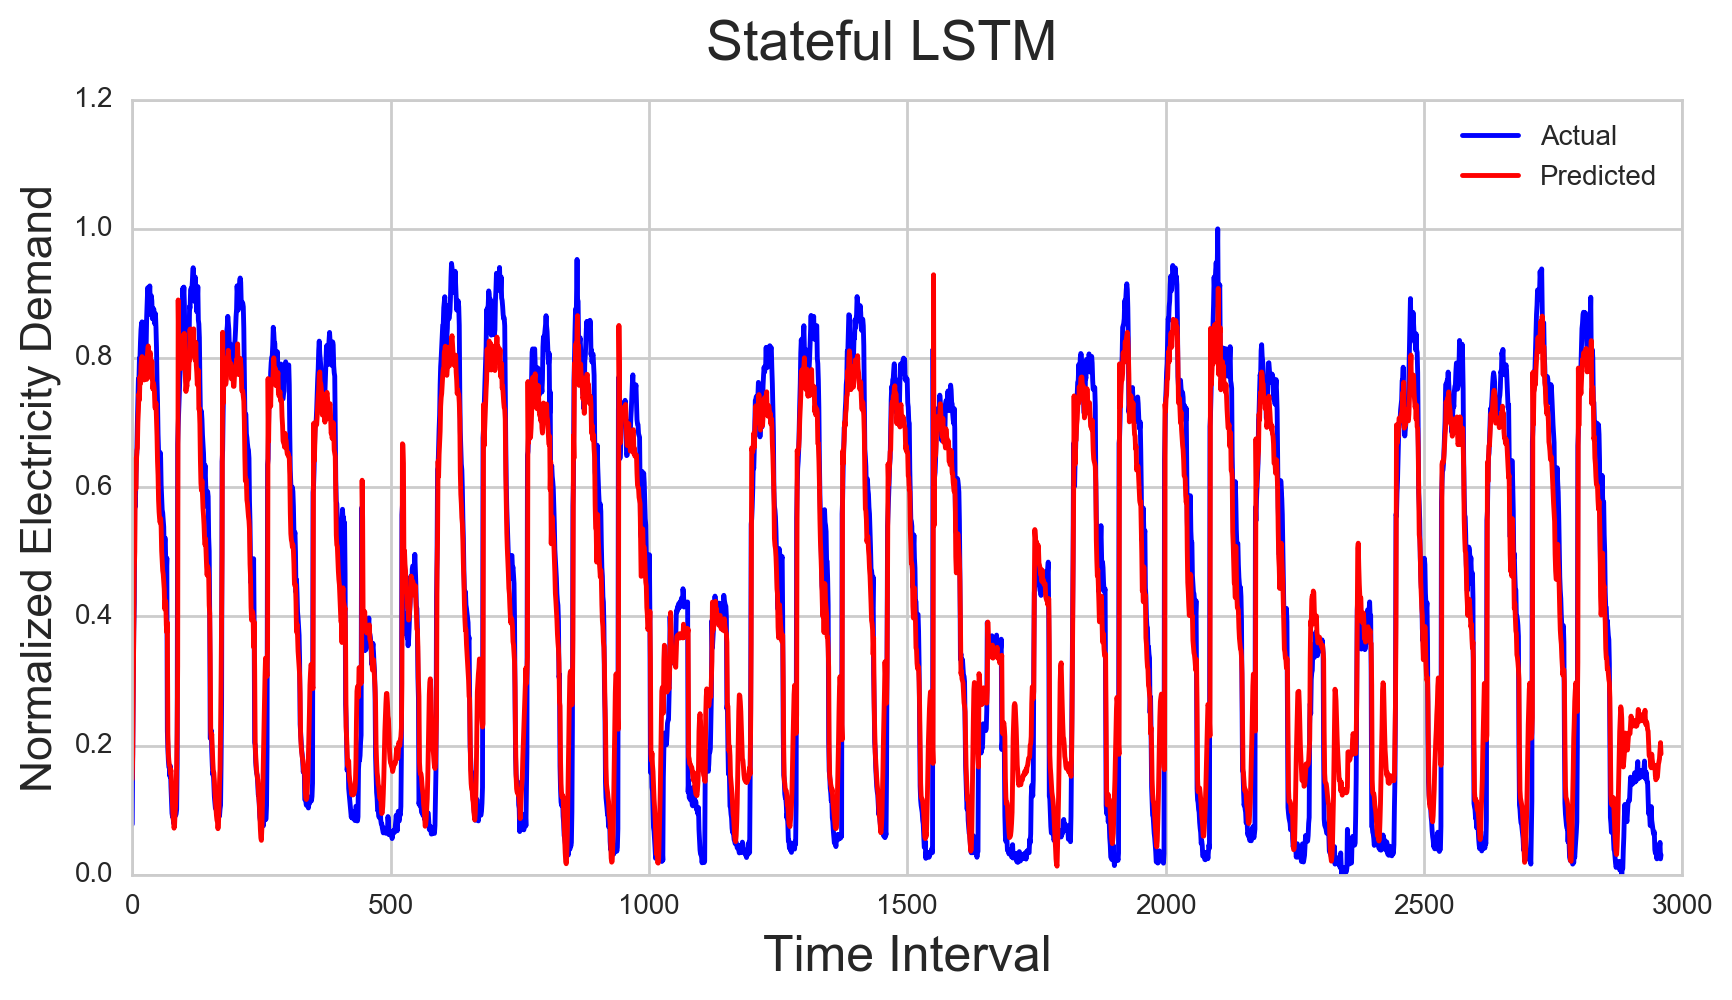

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


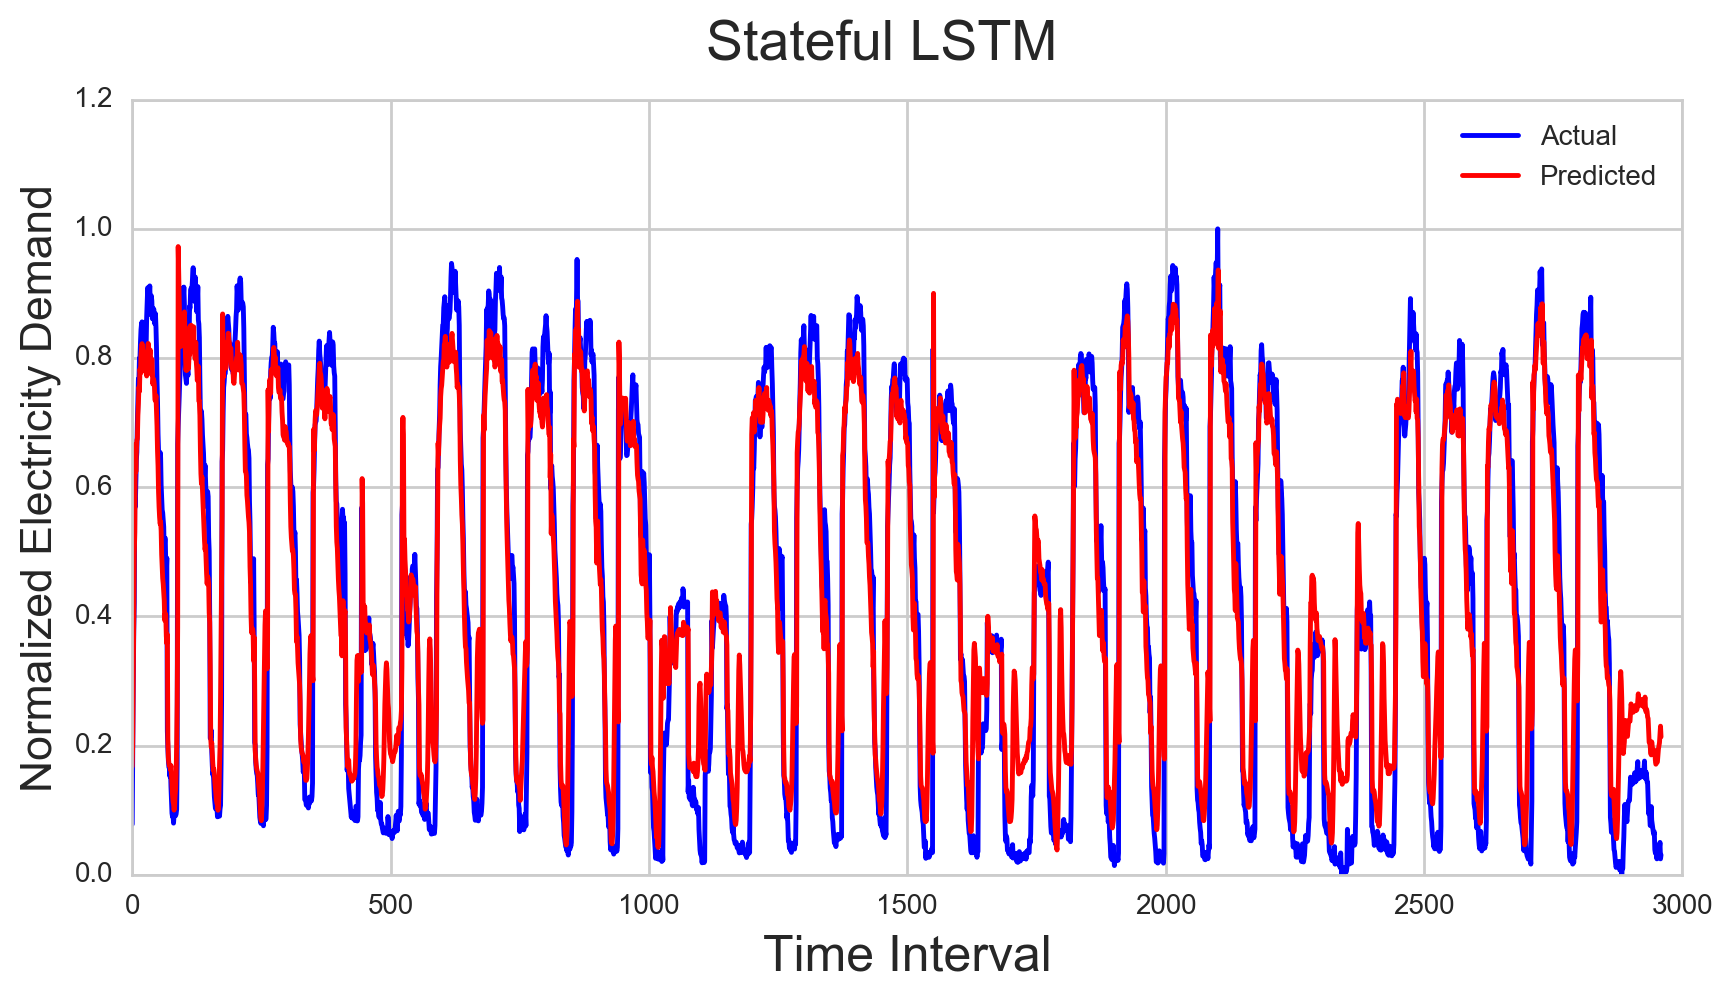

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


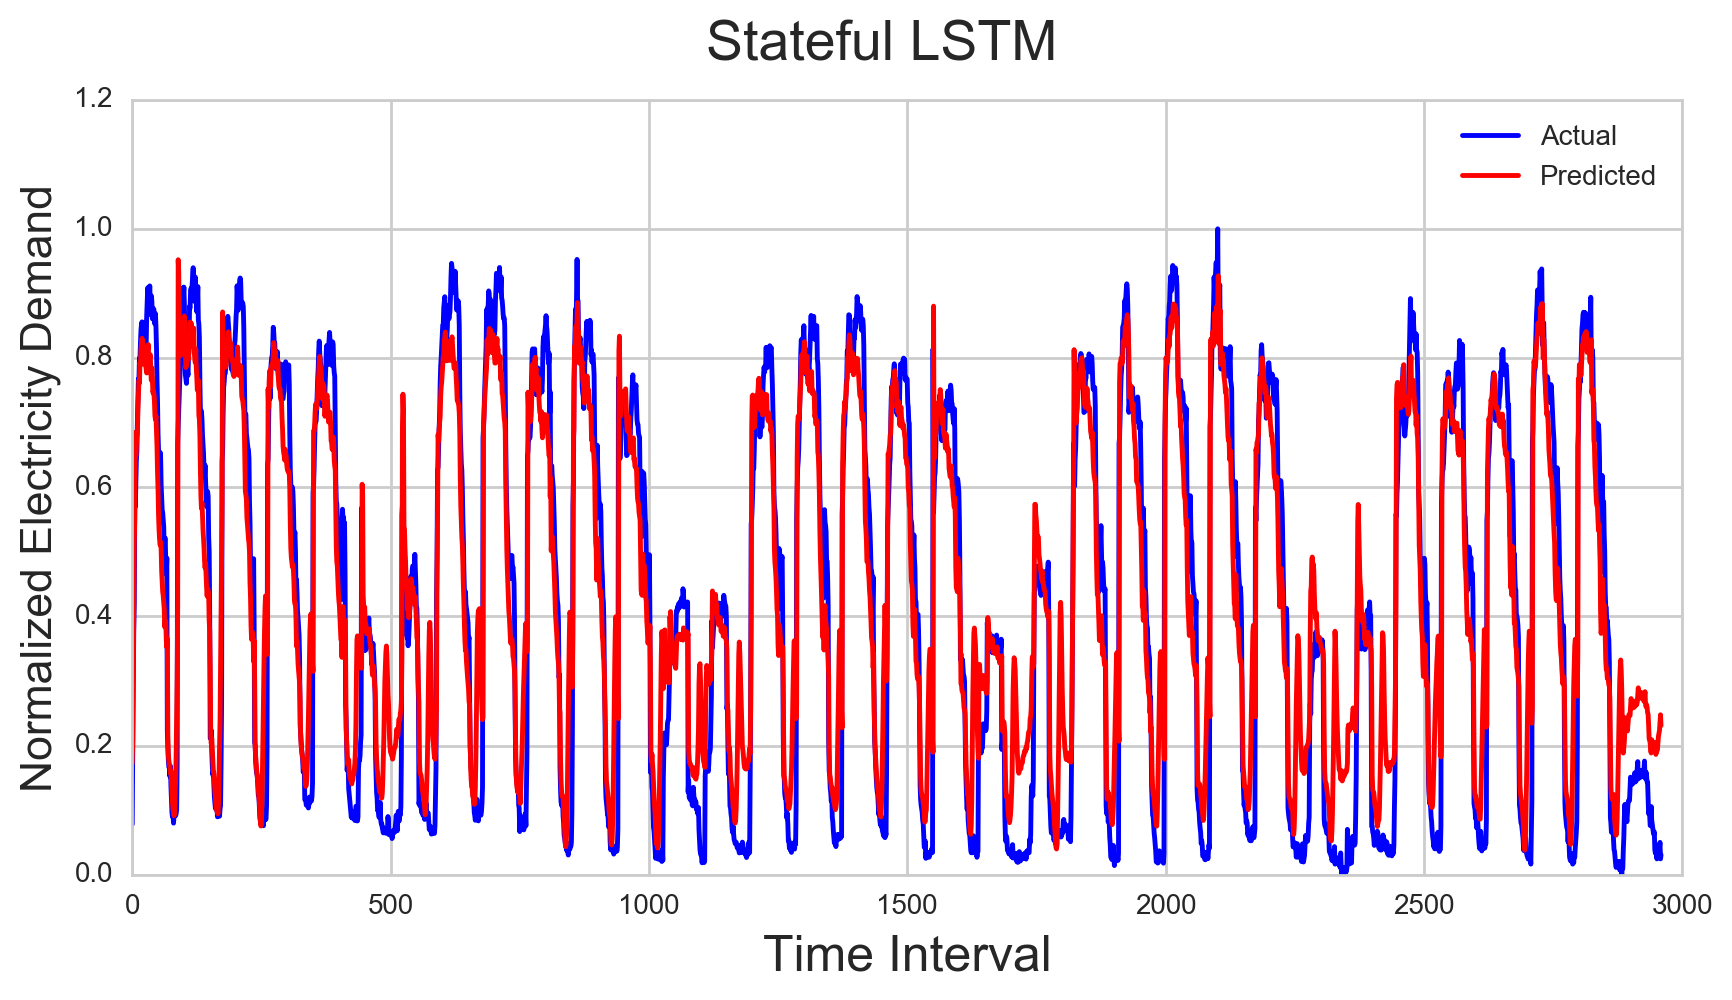

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


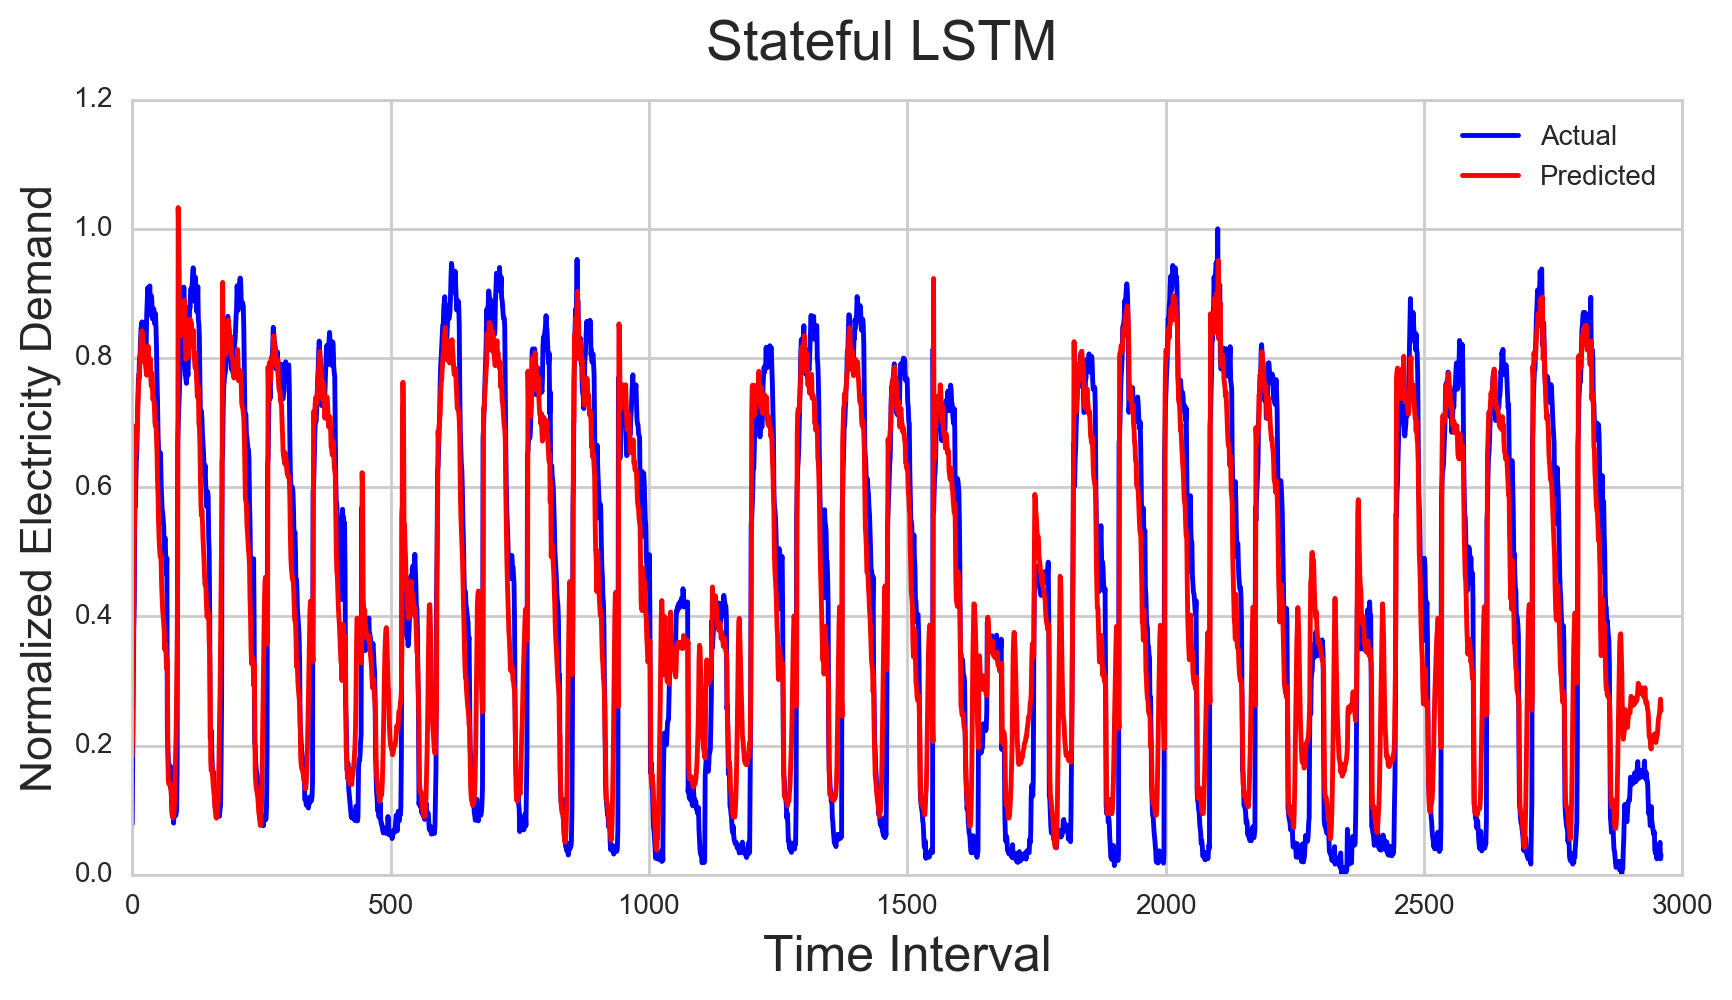

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


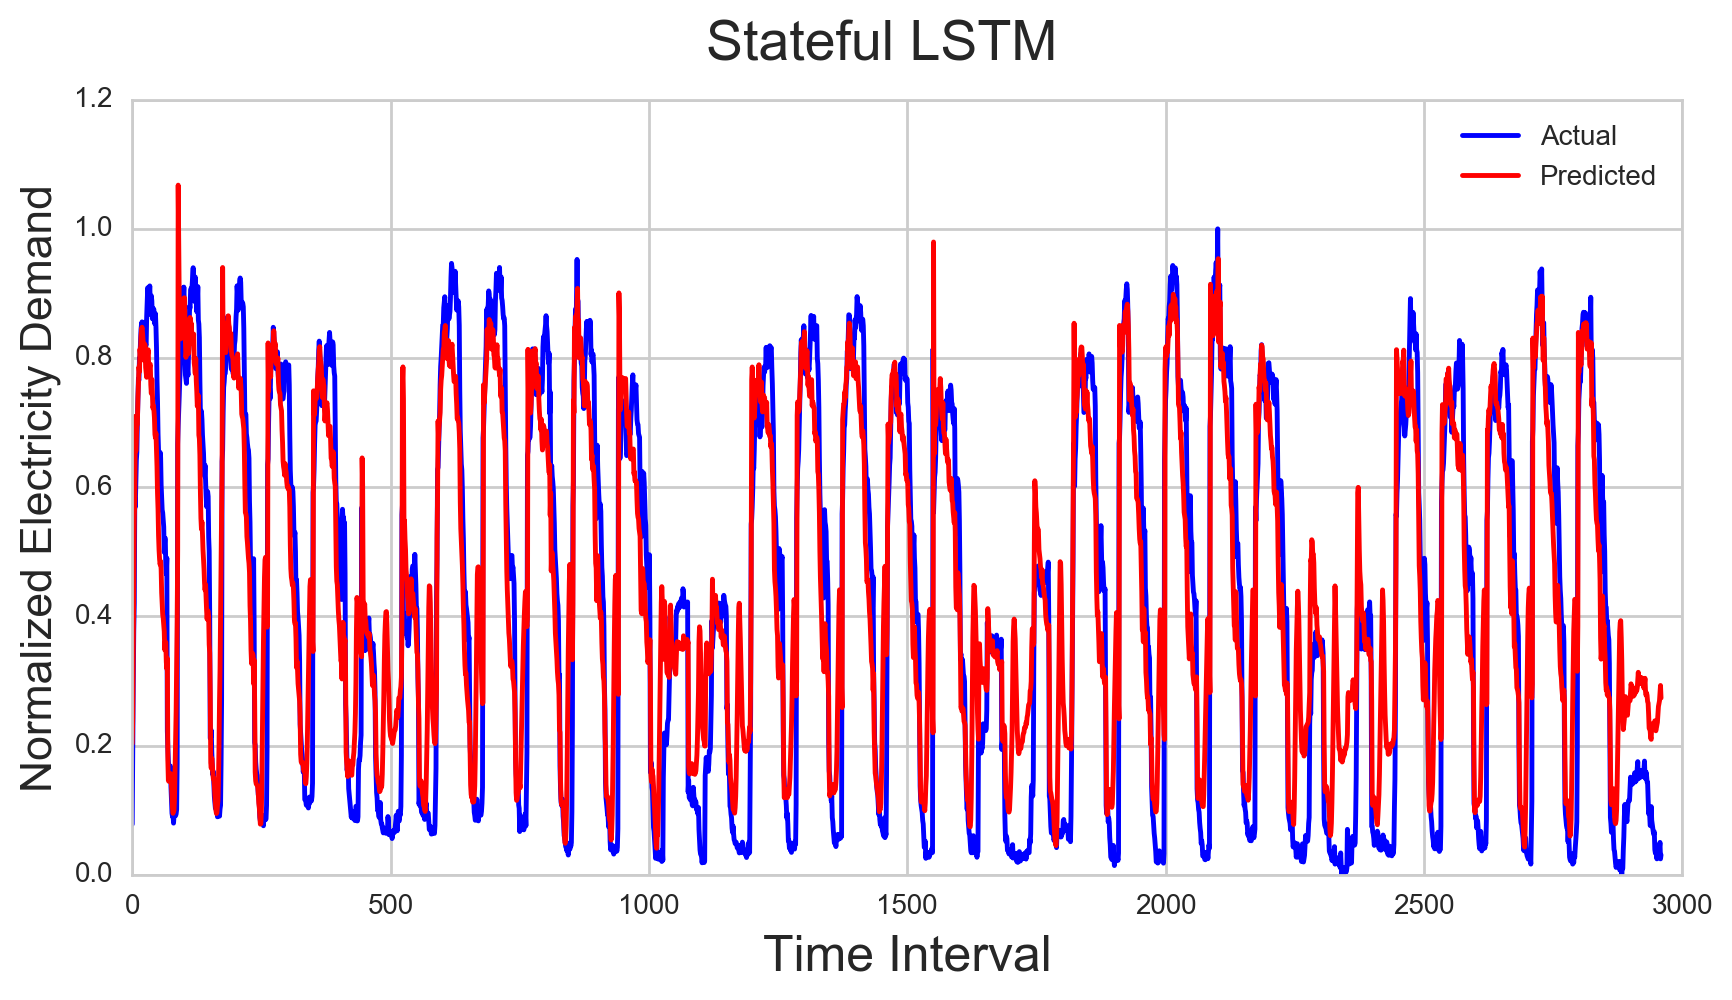

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


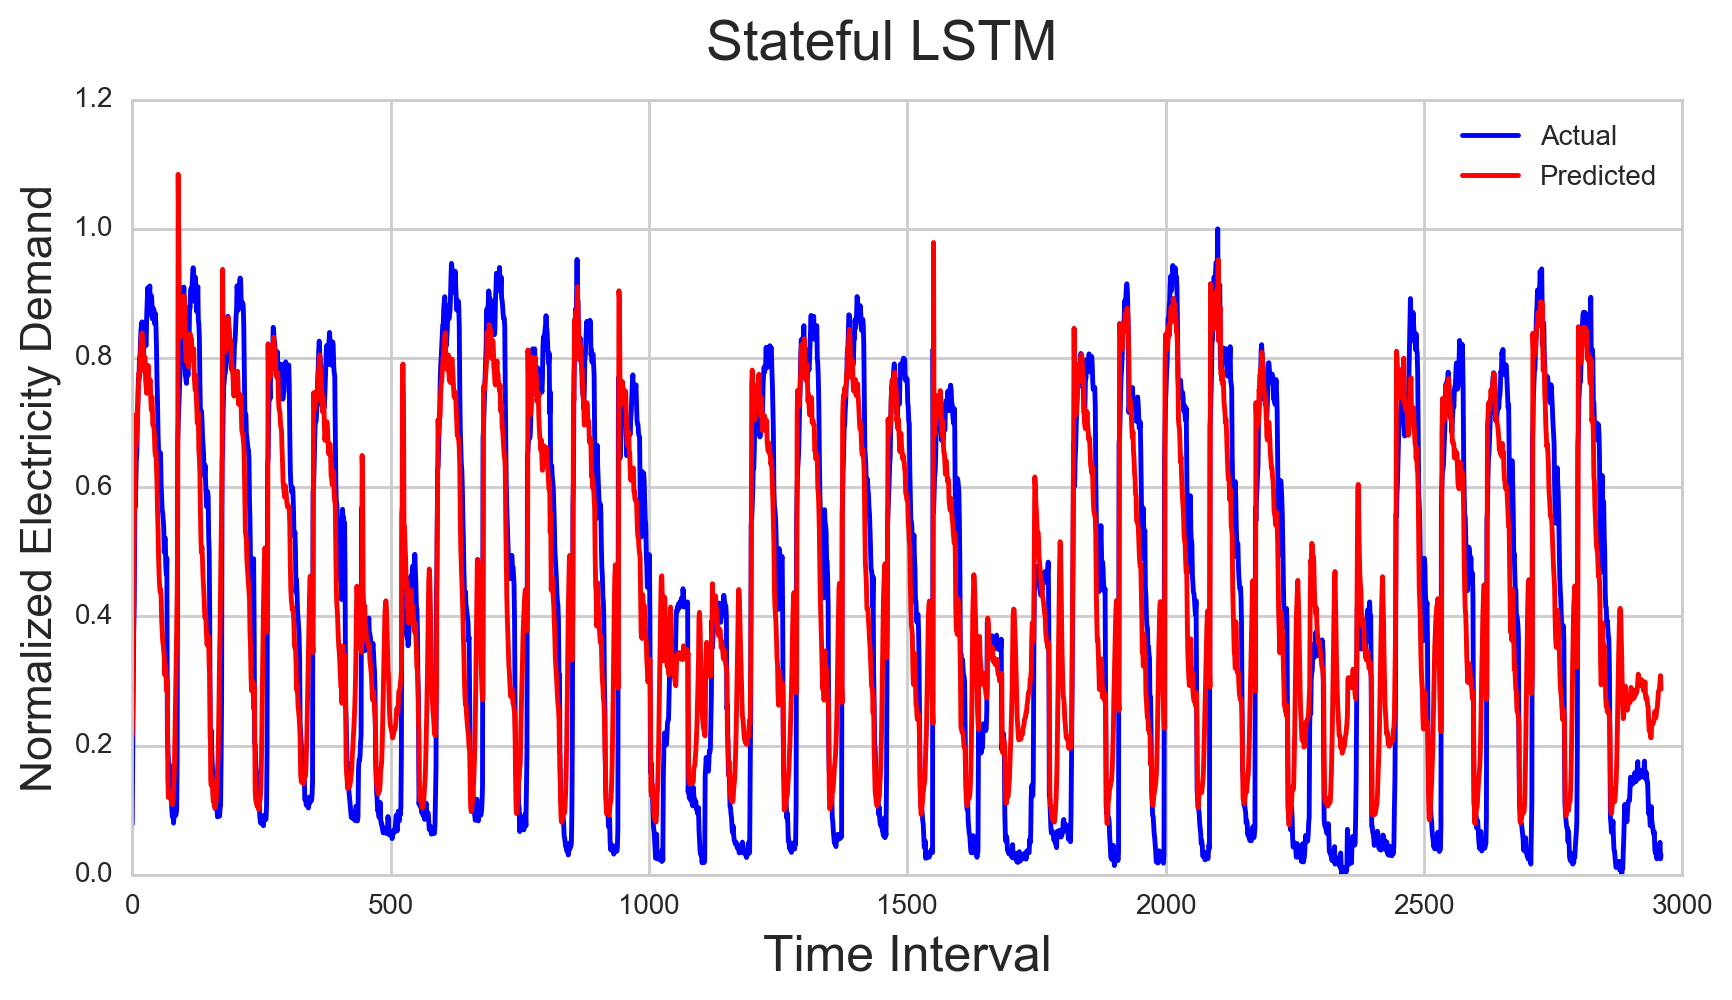

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


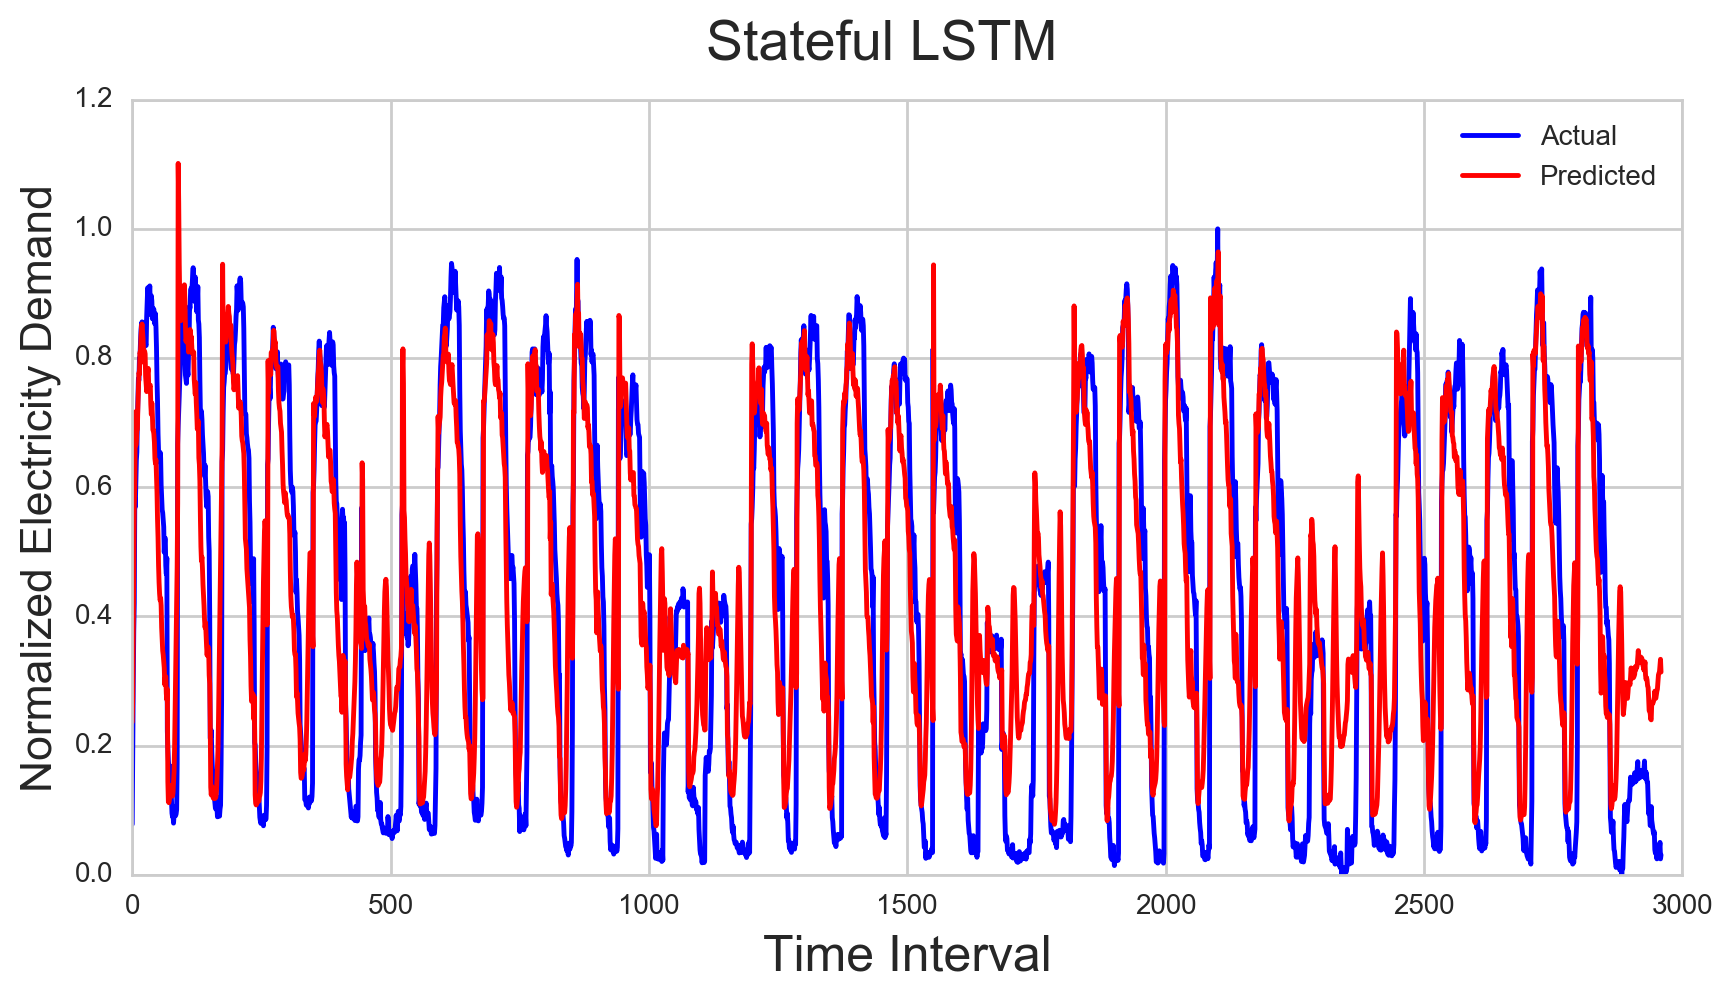

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


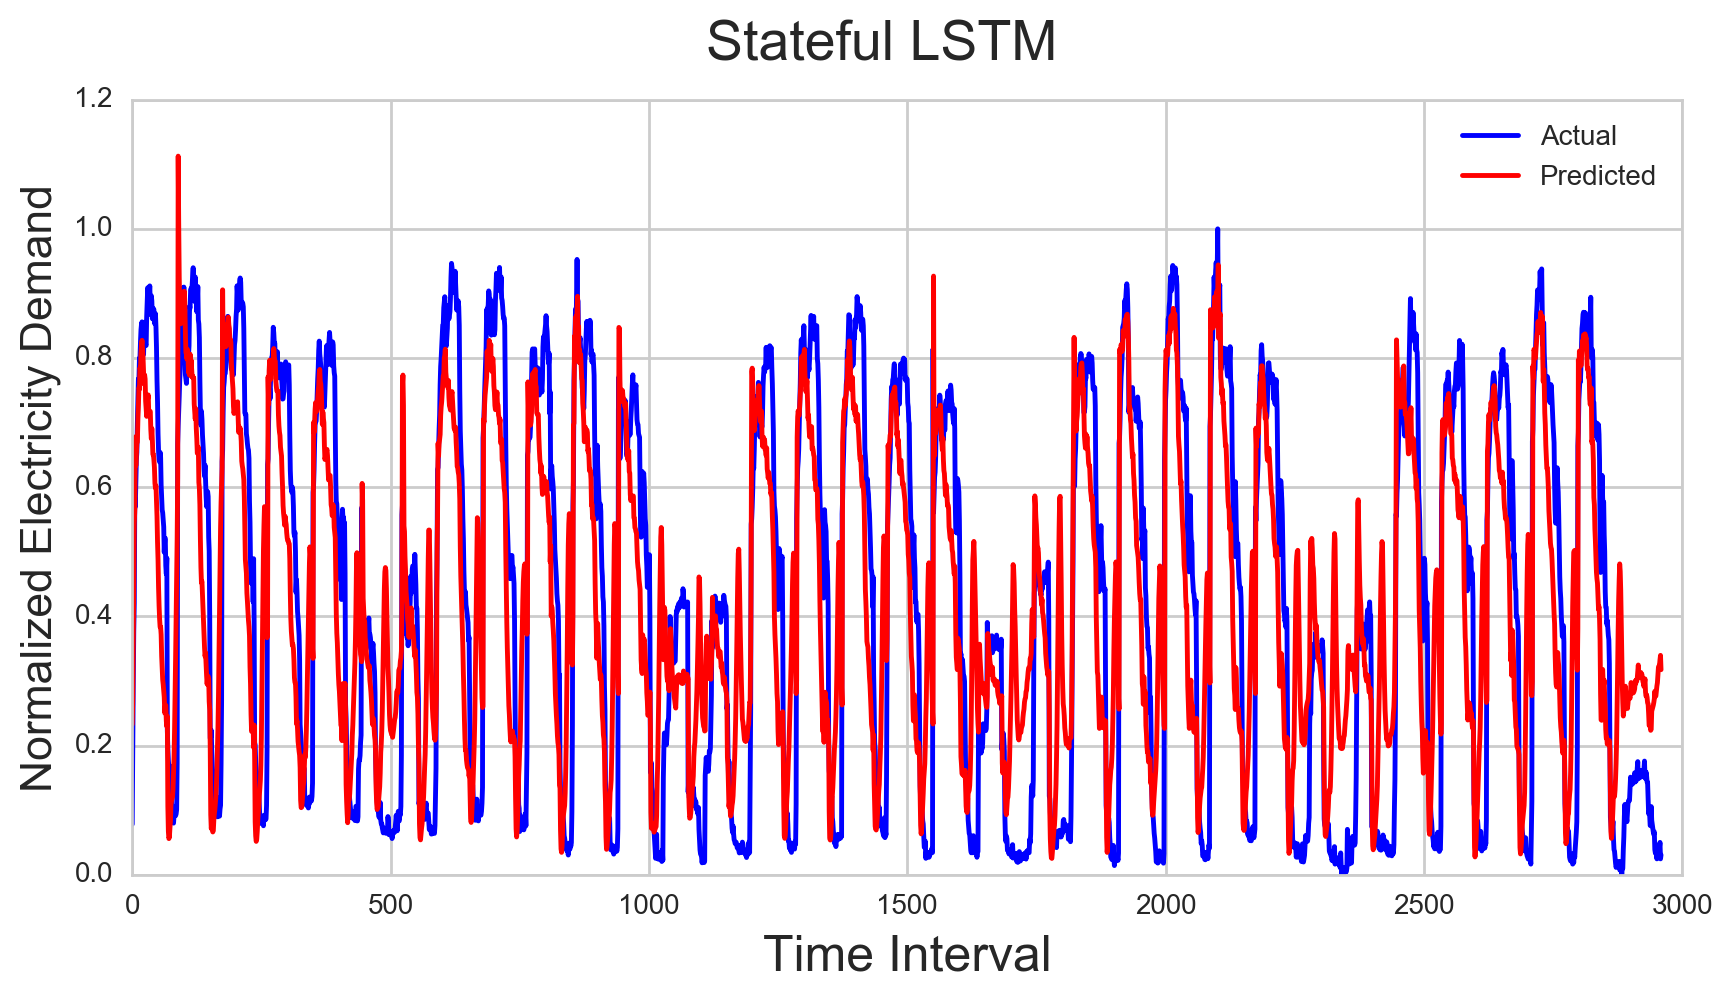

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


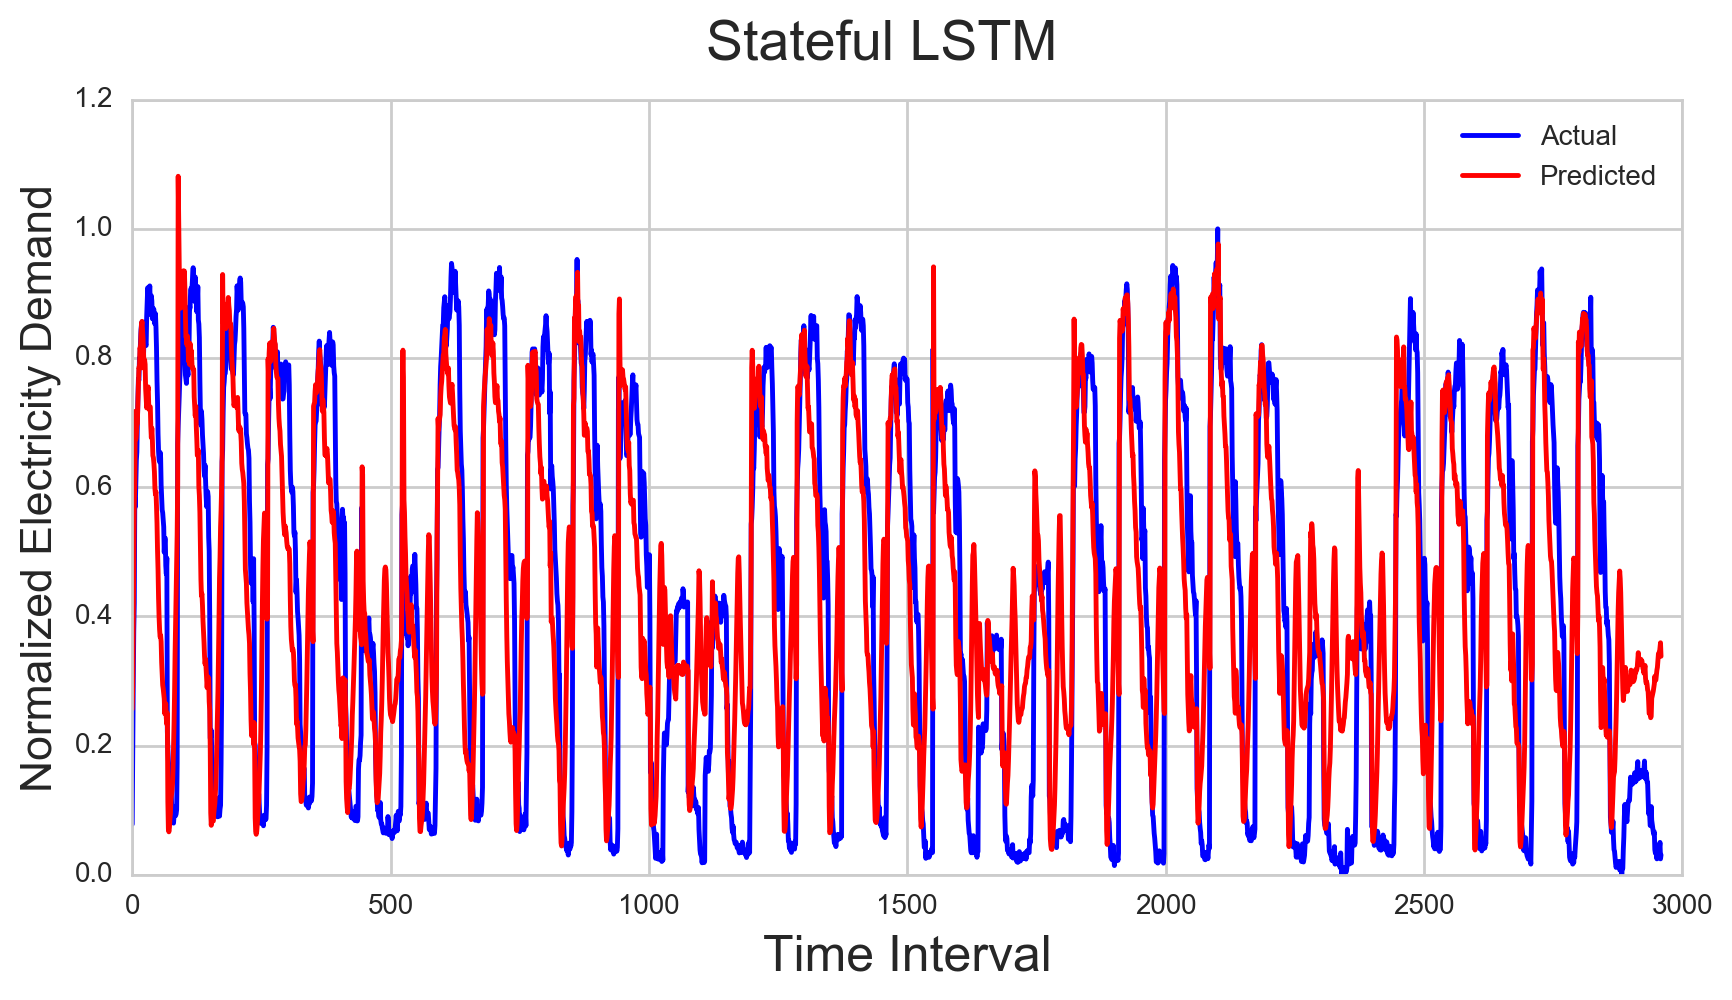

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


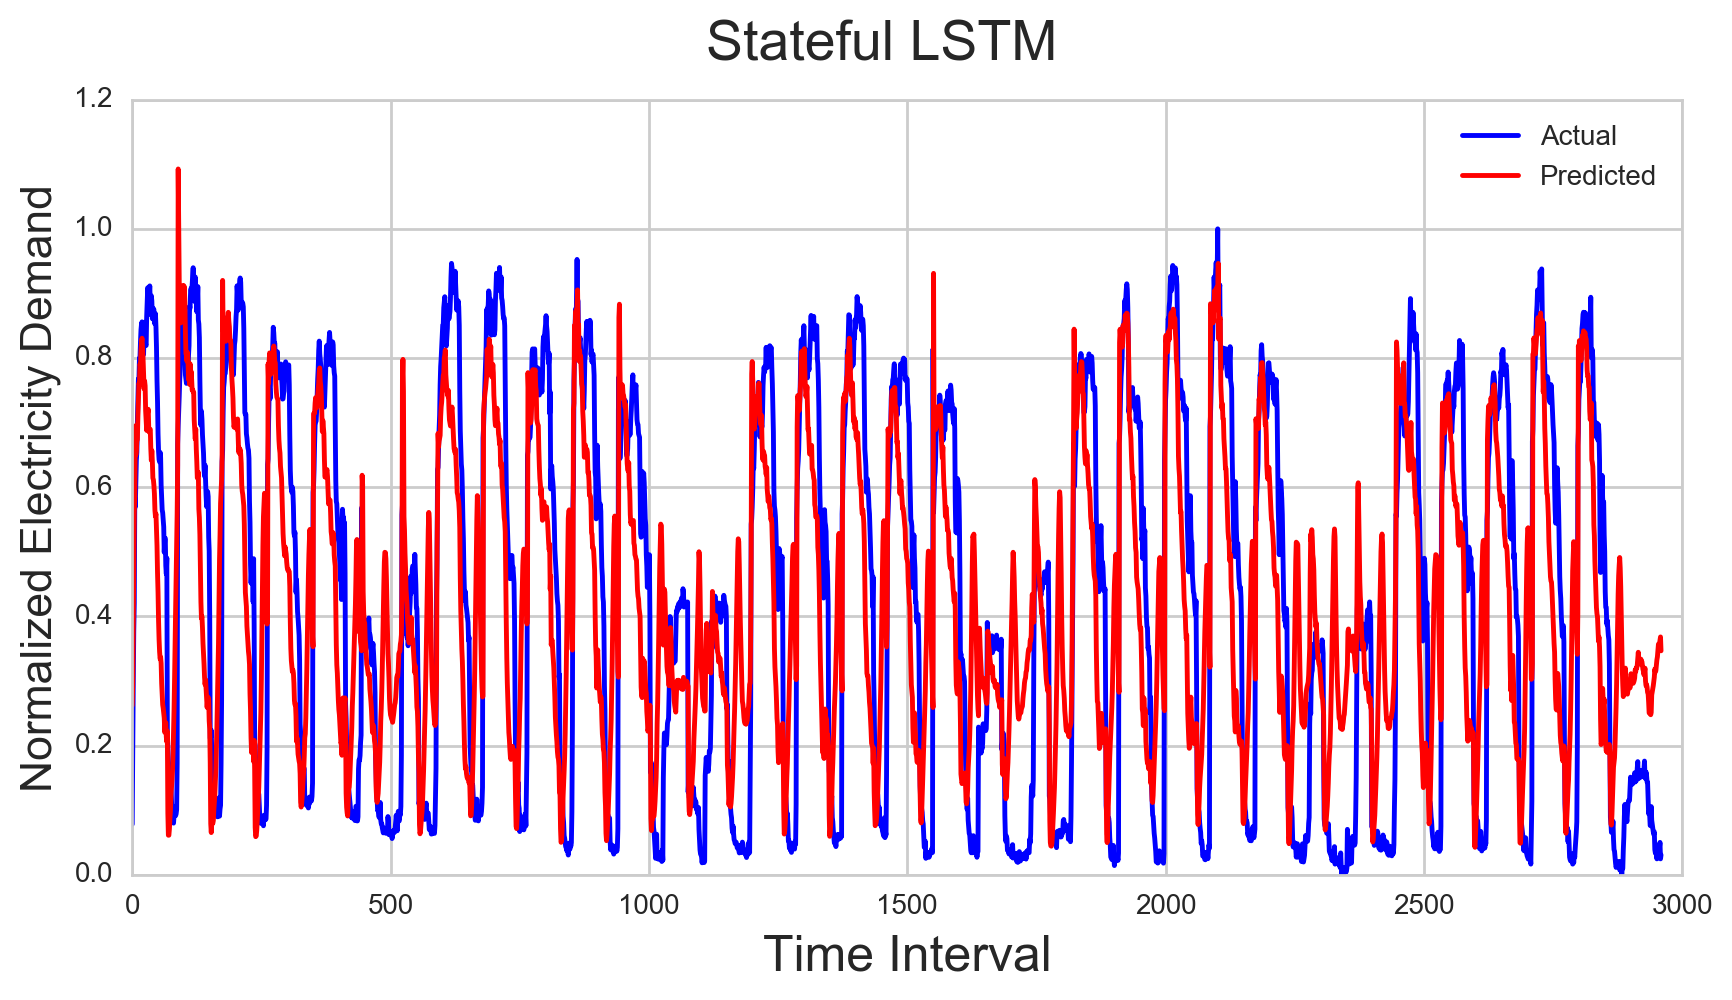

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


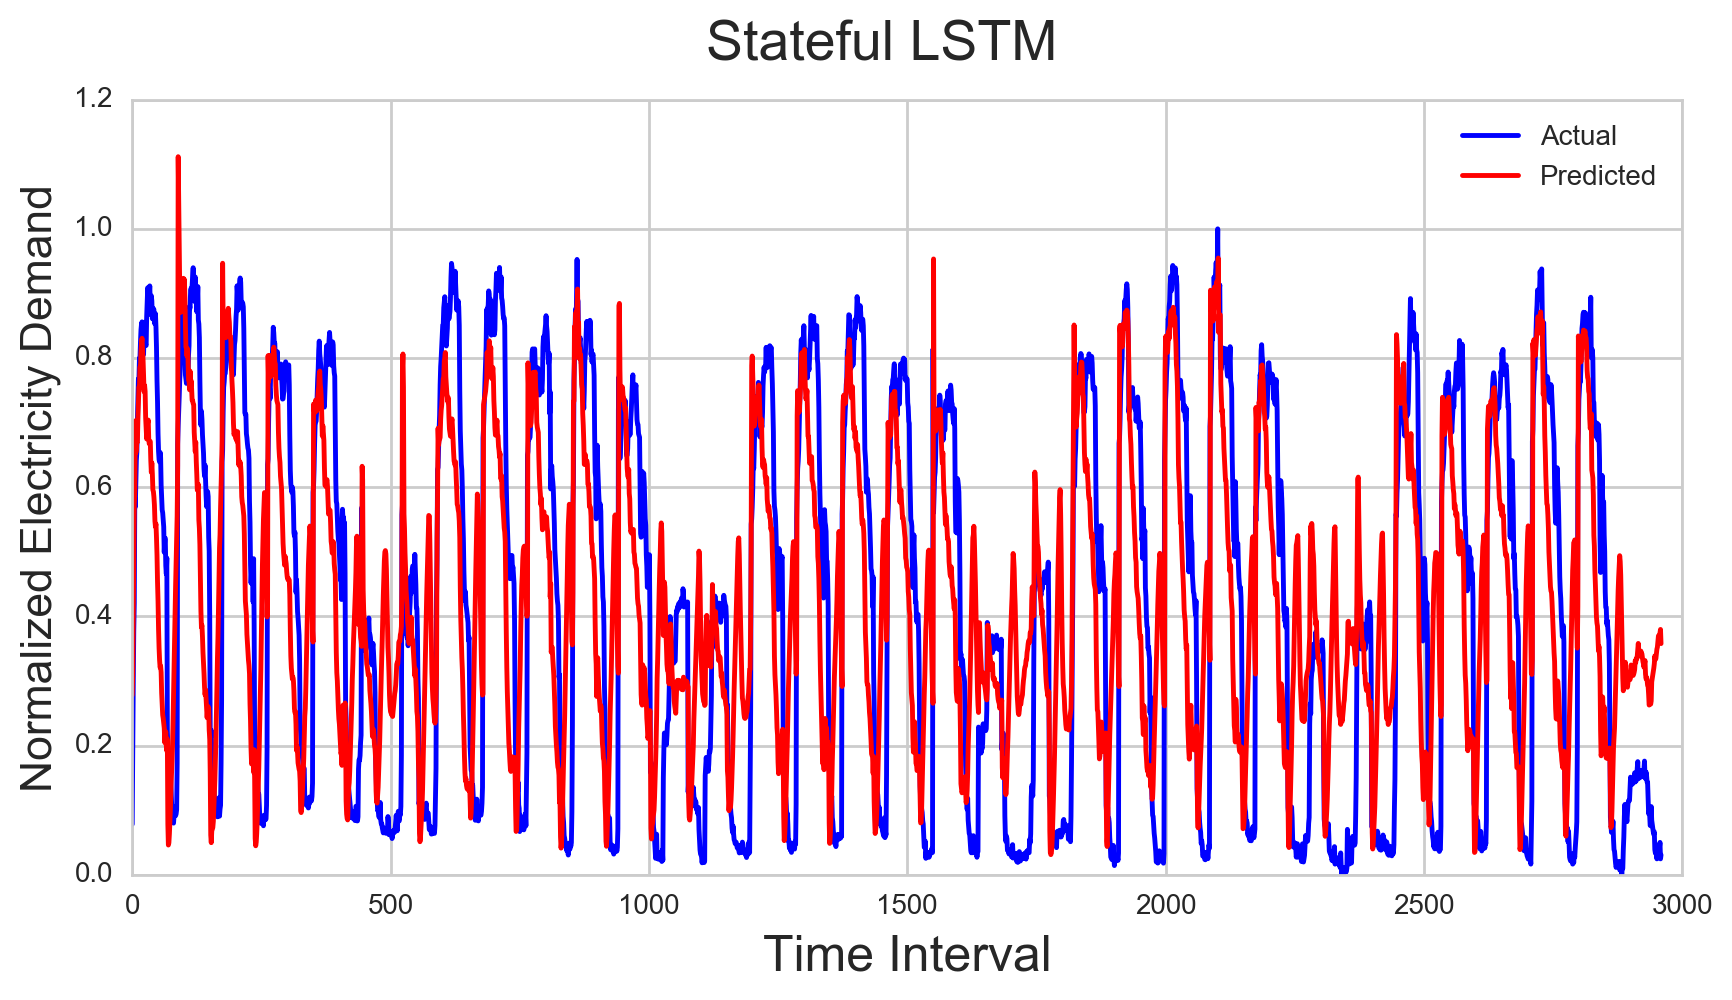

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


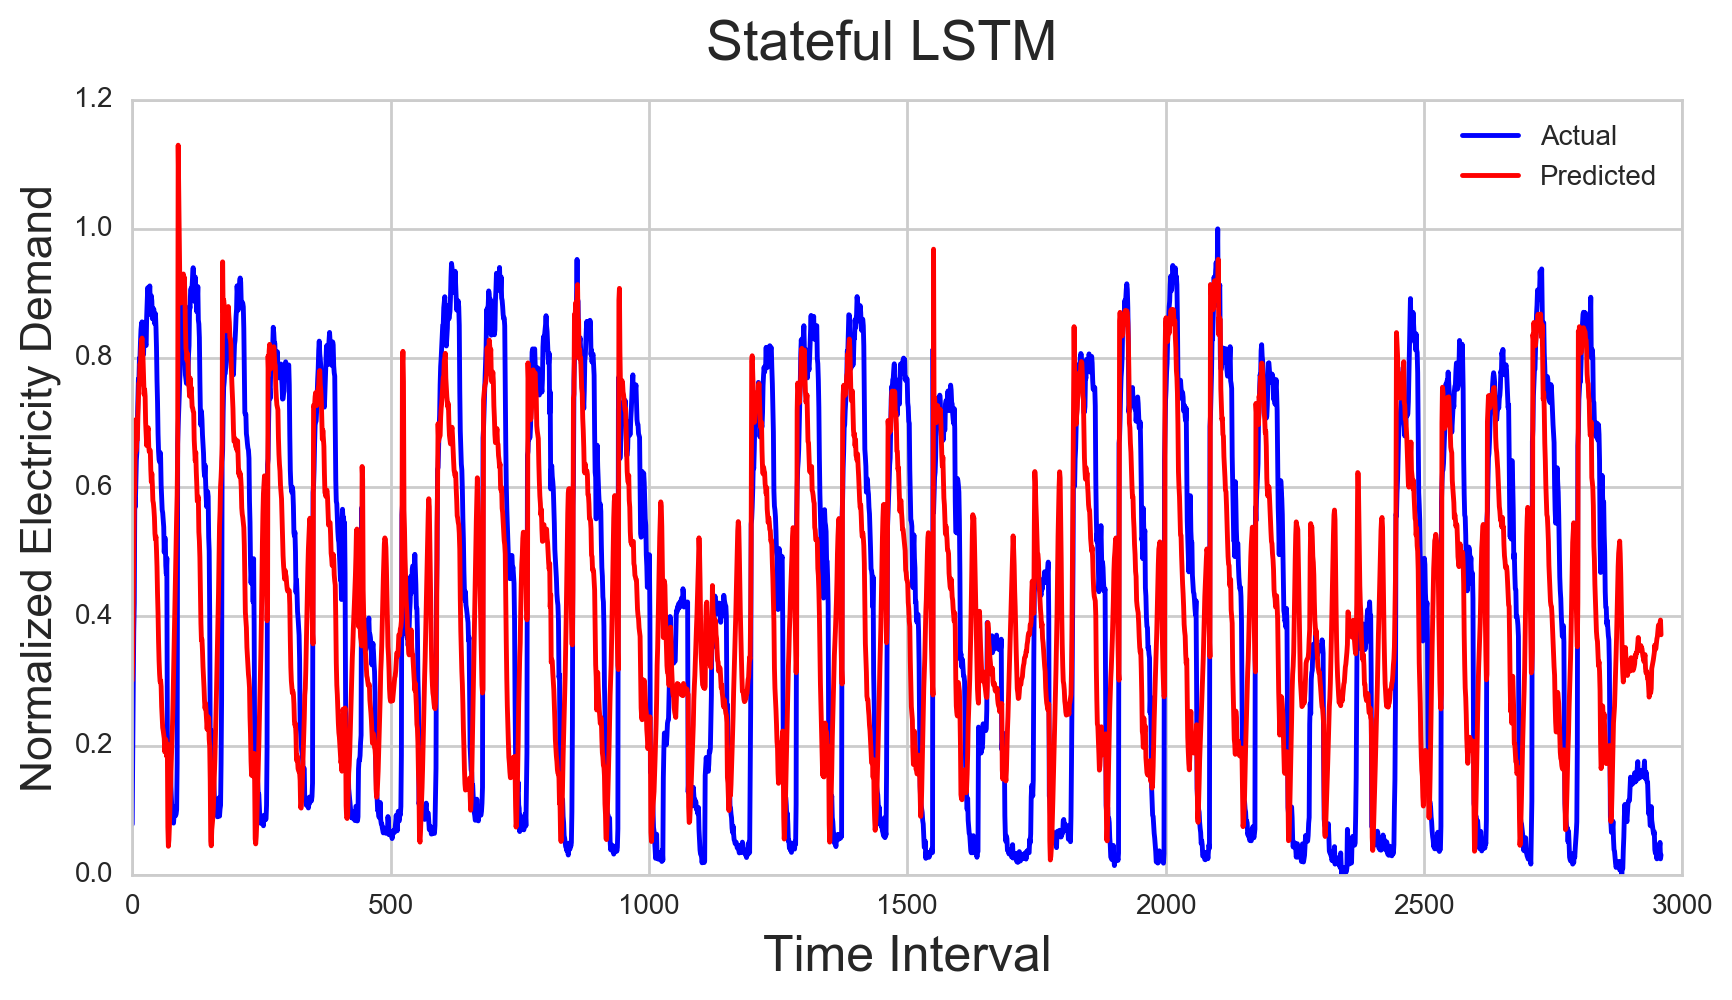

In [54]:
for i in range(15):
    fig, ax = plt.subplots(figsize=(10,5)) 
    plt.plot(scaler.fit_transform(testY[:,0]), color='blue')
    plt.plot(testPredict3[:,i], color='red')
    fig.suptitle('Stateful LSTM', fontsize=20)
    plt.xlabel('Time Interval', fontsize=18)
    plt.ylabel('Normalized Electricity Demand', fontsize=16)
    plt.legend(['Actual', 'Predicted'], loc='upper right')
    plt.show()

# Anomaly Detector

Detects whether the last five collected points are outside of a building's energy consumption envelope. This could be run in parallel with an ARIMA and/or LSTM model to alert users to potential building drift occurring.

Creating an updated studentize function to take in the data as well as some statistical parameters. Second function calculates a moving average of the past 5 studentized residuals. 

In [32]:
def studentize2(data, mean, std):
    
    if std != 0:
        ts = (data - mean) / std
    else: 
        return 1e15
    return ts

def moving_average(iterable, n=5):
    it = iter(iterable)
    d = deque(itertools.islice(it, n-1))
    d.appendleft(0)
    s = sum(d)
    for elem in it:
        s += elem - d.popleft()
        d.append(elem)
        yield s / n

Prototype anomaly detector.

In [ ]:
r = testY[:,np.newaxis] - model.predict(testX)
mean_r = np.mean(testY - model.predict(testX))
std_r = np.std(testY - model.predict(testX))

dq = deque(maxlen=5)
acc = 0
while acc < 1000:
    row = testX[acc]
    y_hat = model.predict(row.reshape(1,1,25))
    y = testY[acc]
    r = y_hat - y
    r_t = studentize2(r, mean_r, std_r)
    
    dq.append(r_t)
    
    try:
        ma = moving_average(dq).next()
    except:
        pass
    
    print "ma is: ", ma
    if  ma >= 0.2 or ma <= -0.2:
        print "Anomaly Detected"
    else:
        pass
        
    acc += 1